<a href="https://colab.research.google.com/github/verkalacheva/pyad-2024/blob/lab4/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22PY%D0%90%D0%94_%D0%9B%D0%A04_Text_Processing_%26_LLM_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_theme("notebook")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Постановка задачи и загрузка данных

В рамках лабораторной работы поработаем снова с реальными данными, содержательно близкими к данным минус первой лабораторной, - про учебные дисциплины. В этот раз займемся обработкой и генерацией описания и содержания дисциплин с помощью языковых моделей.

## Данные

Расположены по ссылке.

In [ ]:
!gdown 1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1

Downloading...
From: https://drive.google.com/uc?id=1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1
To: /content/disciplines_2018_2022.csv
100% 78.8M/78.8M [00:01<00:00, 61.5MB/s]


Из информации о дисциплине у нас есть следующая:
1. `course_id` - номер дисциплины (может повторяться)
2. `course_title` - название дисциплины
3. `description` - краткое описание дисциплины
4. `up_id` - айди учебного плана (образовательной прогарммы)
5. `up_title` - название учебного плана (образовательной прогарммы)
6. `qualification` - уровень образования (бакалавриат или магистратура)
7. `start_year` - год набора
8. `module_name` - название модуля, в который входит дисциплина
9. `contents` – содержание дисциплины (все темы и разделы не по порядку, сплошным текстом)

Данные уже частично предобработаны: датасет содержит только те дисциплины, которые реализовывались более одного года. Это примерно треть от всех дисциплин за 2018–2022 гг.

In [ ]:
df = pd.read_csv("/content/disciplines_2018_2022.csv")
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....


In [ ]:
df.shape

(20502, 9)

Немного погрузимся в данные.

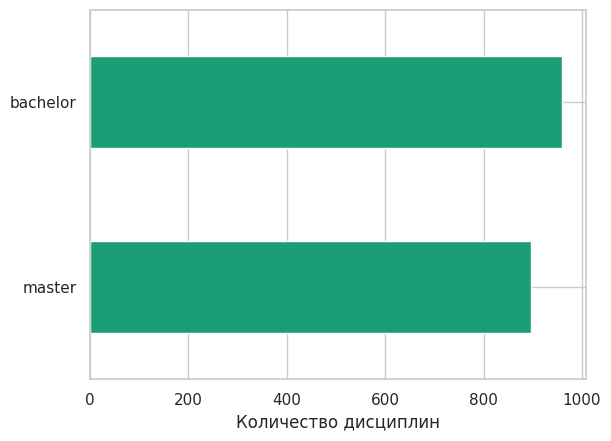

In [ ]:
# количество дисциплин с уникальными названиями по уровням подготовки
df[["course_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество дисциплин")
plt.ylabel("")
plt.show()

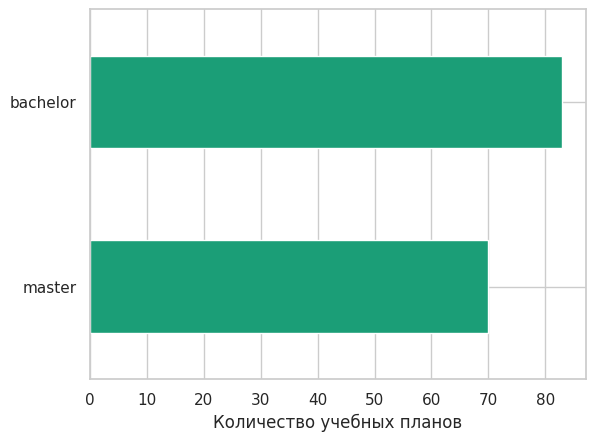

In [ ]:
# количество учебных планов с уникальными названиями по уровням подготовки
df[["up_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество учебных планов")
plt.ylabel("")
plt.show()

Видим, что дисциплин больше (незначительно) в бакалавриате, но учебных планов больше в магистратуре. Это соответствует истине.

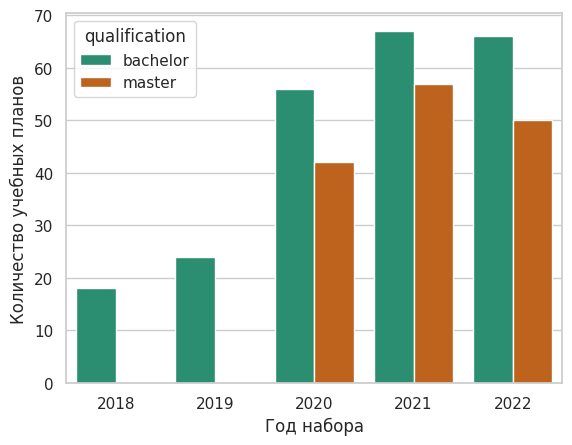

In [ ]:
# количество учебных планов по годам и квалификациям
sns.barplot(data=df[["up_title", "qualification", "start_year"]].drop_duplicates().groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="up_title", hue="qualification")
plt.ylabel("Количество учебных планов")
plt.xlabel("Год набора")
plt.show()

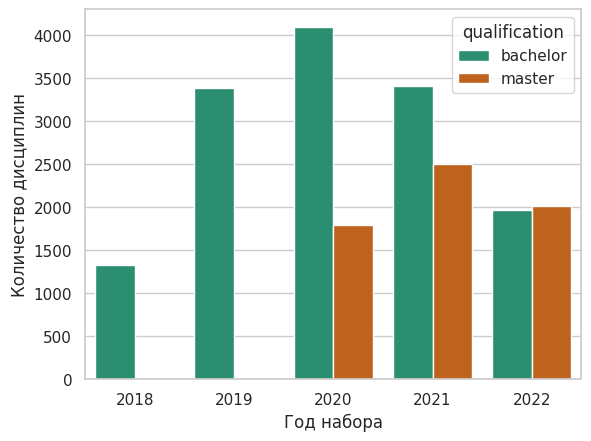

In [ ]:
# количество дисциплин по годам и квалификациям
sns.barplot(data=df[["course_title", "qualification", "start_year"]].groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="course_title", hue="qualification")
plt.ylabel("Количество дисциплин")
plt.xlabel("Год набора")
plt.show()

- Данные по магистратуре начали храниться с 2020 года, по бакалавриату – с 2018, поэтому графики выглядит именно так.
- Учебные планы могут существовать несколько лет с одним и тем же названием (как и дисциплины), поэтому в разрезе по годам уникальных записей больше, чем без него.

## Задача 1 – Предобработать description и contents
1. Выполнить предобработку текстовых данных. Минимально понадобятся следующие шаги предобработки:
  - приведение к одному регистру
  - токенизация
  - удаление пунктуации (можно оставить только буквенные символы в текстах)
  - лемматизация (можно использовать pymystem, он менее точный, чем pymorphy2, но работает в несколько раз быстрее)
2. Построить для дисциплины вектор на основе word2vec
3. Потестировать текстовые представления

Задач не много, но некоторые затратные по времени.

Для предобработки можно воспользовать материалами:
- https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing
- https://colab.research.google.com/drive/16EFOsDbaTF2128kkVMqXxx2Xnb7Gr4mW?usp=share_link

### Предобработка текстовых данных

Проведите предобработку для столбца `contents`.

In [ ]:
!pip install pymorphy2

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from pymystem3 import Mystem # для лемматизации
from nltk.tokenize import word_tokenize, RegexpTokenizer
import string
import pymorphy2


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

m = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
analyzer = pymorphy2.MorphAnalyzer()

In [ ]:
def text_to_wordlist(text, remove_stopwords=False):
    # оставляем только буквенные символы
    text = re.sub("[^а-яА-ЯёЁa-zA-Z]"," ", text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = text.lower().split()
    if remove_stopwords:
      # убираем стоп-слова
        russian_stops = stopwords.words("russian")
        english_stops = stopwords.words("english")
        stops = stops = set(russian_stops + english_stops)
        words = [w for w in words if not w in stops]
    norm_words = [analyzer.parse(word)[0].normal_form for word in words]
    return norm_words

def text_to_sentences(text, tokenizer, remove_stopwords=False):
    raw_sentences = tokenizer.tokenize(text.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(text_to_wordlist(raw_sentence, remove_stopwords=True))


    return sentences

In [ ]:
df["contents_new"] = df["contents"].apply(lambda text: text_to_sentences(text, tokenizer)[0])

In [ ]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг]"
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят..."


Проведите предобработку для столбца `description`.

In [ ]:
df["description_new"] = df["description"].apply(lambda text: text_to_sentences(text, tokenizer)[0])

In [ ]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,description_new
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг]","[цель, курс, предоставить, возможность, магист..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составить, соответствие, требовани..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[дать, дисциплина, учить, планировать, меропри..."


Данные минимально предобработаны. Можно переходить к векторизации. Рассмотрим два подхода:
- Word2Vec, обученный на предобработанных данных
- Tiny BERT – предобученная мини-версия мультиязычного BERT

### Кратко про языковые модели

Вне зависомости от того, большая модель или нет, данные, на которых она обучается и тестируется проходят одинаковые этапы предобработки.

Перед тем как начать обучение модели, необходимо подготовить текстовые данные. Этот процесс включает несколько этапов:

-	**Сбор данных.**

Модель обучается на большом корпусе текстов, который может включать книги, статьи, блоги, форумы и другие источники. Чем больше и разнообразнее данные, тем лучше модель сможет понять и воспроизвести язык.
-	**Токенизация.**

Процесс разбиения текста на отдельные элементы, называемые токенами. Токены могут представлять собой слова, части слов или даже отдельные символы. Например, фраза «Как дела?» может быть токенизирована как [«Как», «дела», «?»].
-	**Создание словарей.**

После токенизации формируется словарь, который сопоставляет с каждым токеном уникальный идентификатор. Этот словарь необходим для перевода текстовых данных в числовую форму, понятную модели.
-	**Преобразование текста в числовые векторы.**

Токены преобразуются в числовые векторы, которые будут использоваться в качестве входных данных для нейронной сети. Эти векторы могут быть статическими, как в Word2Vec, или динамическими, как в трансформерах.

---
Обучение языковой модели заключается в настройке её параметров на основе текстовых данных, чтобы она могла предсказывать следующее слово или генерировать осмысленные фразы.

-	**Forward propagation (прямой проход).**

На этом этапе данные проходят через слои нейронной сети, где каждое слово представляется в виде вектора. Эти векторы затем преобразуются в промежуточные состояния, которые несут информацию о контексте текста.
-	**Механизм внимания.**

В современных моделях, таких как трансформеры, используется механизм внимания, который позволяет модели выделять наиболее важные части текста, на которых нужно сосредоточиться при генерации или предсказании.
-	**Обратное распространение ошибки (Backpropagation).**

После того как модель сделала предсказание, она сравнивает его с реальными данными и вычисляет ошибку. Затем эта ошибка используется для корректировки параметров модели, чтобы улучшить точность предсказаний в будущем.
-	**Обучение на основе батчей.**

Данные разбиваются на небольшие группы — батчи, которые подаются модели для обучения. Этот метод позволяет эффективно использовать вычислительные ресурсы и ускорять процесс обучения.

Трансформеры
Современные языковые модели в большинстве основаны на архитектуре трансформеров, предложенной в 2017 году. Трансформеры решают многие проблемы, присущие RNN, и становятся доминирующим подходом в NLP.

-	**BERT (Bidirectional Encoder Representations from Transformers).**

Модель BERT использует двунаправленное обучение, что позволяет ей понимать контекст слова как слева, так и справа от него. Это делает BERT особенно мощным инструментом для задач, связанных с пониманием текста, таких как вопросо-ответные системы и анализ тональности.
-	**GPT (Generative Pre-Trained Transformer).**

Модель GPT, напротив, использует однонаправленное обучение, предсказывая следующее слово только на основе предыдущих слов. Эта модель, особенно в версиях GPT-2 и GPT-3, стала чрезвычайно популярной для генерации текста благодаря своей способности создавать связные и осмысленные сообщения, которые трудно отличить от текстов, написанных человеком.

### Векторизация word2vec

In [ ]:
from gensim.models import Word2Vec
import gensim

In [ ]:
# обучим на своих данных модель word2vec
# min_count – минимальная частота слова в корпусе
# vector_size – размер вектора для слова
# workers – количество потоков
# window – окно контекста, в которое попадает слово

w2v_model = Word2Vec(df['description_new']+df['contents_new'], min_count=1, vector_size=300, workers=2, window=10)

In [ ]:
w2v_model_path = "w2v.bin" # будет удобно сохранить модель, если выполняете лабу не за один вечер
w2v_model.save(w2v_model_path)

In [ ]:
# загрузка сохраненной модели
w2v_model = gensim.models.Word2Vec.load(w2v_model_path)

In [ ]:
# так выглядит один вектор
print(w2v_model.wv.get_vector("обучение").shape)  # размер вектора
w2v_model.wv.get_vector("обучение")

(300,)


array([-0.13842006,  0.71470094,  0.14183271, -0.5631092 ,  0.95944005,
       -0.46418342,  0.38705084,  0.66160756, -1.3657864 ,  0.5089874 ,
        1.58321   ,  1.5127851 , -0.71176577,  0.31988272, -0.14273651,
       -0.09690076, -0.6930507 ,  0.9080609 , -1.0404744 , -0.2637191 ,
        0.46021384, -0.33056006, -0.00282887, -0.46058568, -0.6167983 ,
        0.4013535 , -0.26910278, -0.42401293, -0.23383254, -0.9019516 ,
       -0.28745872, -1.3364321 ,  0.9056656 , -0.0425851 , -0.15570973,
        0.35780007, -1.1870043 ,  1.204475  ,  0.41989887, -0.0244797 ,
       -0.3236659 ,  0.14390503,  0.38764703, -0.4671663 , -0.5463235 ,
        0.551299  ,  0.01350341,  0.6883462 ,  1.1210256 ,  0.8556001 ,
        0.28367493,  0.04691203, -0.18506527, -0.6961563 ,  0.4922681 ,
       -0.13781597,  0.1547089 ,  0.57356787,  0.35351387, -1.019944  ,
       -0.18787941,  0.19394189, -0.6403398 ,  1.131926  ,  0.0845952 ,
        0.08119277,  0.00692569,  1.1123116 ,  0.20578128,  1.09

In [ ]:
# слова, максимально близкие к "машинному обучению"
w2v_model.wv.most_similar(["обучение", "машинный"])

[('интеллект', 0.7828409075737),
 ('искусственный', 0.7518596053123474),
 ('подкрепление', 0.7337433695793152),
 ('владение', 0.6769990921020508),
 ('достижение', 0.659147322177887),
 ('алгоритм', 0.6490740180015564),
 ('освоить', 0.6447198390960693),
 ('прикладной', 0.6332773566246033),
 ('письменный', 0.6292430758476257),
 ('следующий', 0.628853440284729)]

In [ ]:
# слова, максимально близкие к "анализу данных"
w2v_model.wv.most_similar(["анализ", "данные"])

[('алгоритм', 0.8135326504707336),
 ('сортировка', 0.7257223725318909),
 ('визуализация', 0.7138645648956299),
 ('обработка', 0.7074813842773438),
 ('имитационный', 0.6841254830360413),
 ('речь', 0.6837385296821594),
 ('реализовывать', 0.6774299740791321),
 ('дашбордовый', 0.6729577779769897),
 ('колоночный', 0.6596909761428833),
 ('бинс', 0.6596882939338684)]

Семантически получились не идеальные, но в целом близкие списки. Это естественно, т.к. уникальных записей для обучения было передано около 2000.

Создадим два вектора для каждой дисциплины:
1. По данным содержания (`contents`)
2. По данным описание дисциплины (`description`)

Учитывайте, что должна быть возможность построить эмбеддинг для нового текста, даже если некоторые слова отсутствуют в исходной модели. При этом вектор не должен быть нулевым. Для этого напишите функцию `embed()`, в качестве агрументов принимающую список токенов текста и модель.

Вектором текста должно являться среднее всех векторов слов текста.

In [ ]:
import numpy as np

In [ ]:
def embed(tokens, w2v_model):
    word_vectors = []

    for token in tokens:
        if token in w2v_model.wv:
            word_vectors.append(w2v_model.wv[token])
        else:
            word_vectors.append(np.zeros(w2v_model.vector_size))

    if len(word_vectors) == 0:
        return np.zeros(w2v_model.vector_size)

    # Вычисляем среднее всех векторов
    text_vector = np.mean(word_vectors, axis=0)

    return text_vector

# пример вектора
embed(df.iloc[0].contents_new, w2v_model)

array([-2.04495624e-01, -1.32371979e-02,  7.81338751e-01, -4.92426366e-01,
       -1.41178310e-01, -4.12935019e-01, -2.73889571e-01,  4.29333180e-01,
        1.53337047e-01, -1.67080328e-01,  1.07035244e+00,  1.78396955e-01,
        7.51869678e-01,  1.24209154e+00,  3.05491835e-01, -9.47216034e-01,
        7.10188329e-01, -7.15794191e-02,  8.31260502e-01, -5.67462504e-01,
       -5.15515089e-01, -6.22492969e-01, -2.71754503e-01,  4.90578741e-01,
        4.08459306e-01, -9.66263488e-02, -6.93451226e-01,  4.48406607e-01,
       -8.60057101e-02,  4.83319014e-01, -6.77497566e-01, -1.24857508e-01,
        4.88750070e-01,  4.97573704e-01,  5.03259361e-01,  6.06059611e-01,
       -8.27357769e-01, -4.90401119e-01, -2.46577457e-01, -2.29145095e-04,
       -8.88840377e-01, -7.66592681e-01,  6.64869249e-01,  6.08652830e-01,
       -2.79721051e-01,  1.41377106e-01, -7.37710297e-02, -1.06125891e-01,
        3.42855304e-01,  3.17750394e-01, -2.73947924e-01, -1.28699765e-01,
        6.31150370e-03,  

Теперь применим функцию `embed()` для формирования вектора для содержаний и кратких описаний в каждой записи.

In [ ]:
df['contents_embedding'] = df['contents_new'].apply(lambda x: embed(x, w2v_model))
df['description_embedding'] = df['description_new'].apply(lambda x: embed(x, w2v_model))
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,description_new,contents_embedding,description_embedding
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг]","[цель, курс, предоставить, возможность, магист...","[-0.9867507, 0.59560335, 0.2158096, -1.0835512...","[-0.69002604, 0.27199325, 0.082059555, -0.7921..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составить, соответствие, требовани...","[-0.015672177, 0.46538958, -0.045063276, 0.198...","[-0.18337621, 0.32341155, 0.31151345, -0.46322..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[дать, дисциплина, учить, планировать, меропри...","[-0.3442846, 0.7179183, 0.17016207, -0.6916874...","[-0.17791948, 0.39518368, 0.18778795, -0.18329..."


Оценим, насколько семантически близки краткие описания дисциплин и темы в содержании. Для оценки воспользуемся косинусным сходством.

$$K(X, Y) = \frac{X \cdot Y} {||X||*||Y||}$$

В `sklearn` функция для расчета косинусного сходства генерирует матрицу результатов, мы будем сравнивать всего два вектора, поэтому напишем свою обертку для функции из `sklearn` так, чтобы она возвращала одно числовое значение, а не матрицу.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def cosine_similarity(vec1, vec2):
    # Вычисляем косинусное сходство и возвращаем единственное значение
    vec1, vec2 = np.array(vec1), np.array(vec2)
    if vec1.ndim ==1:
      return cs([vec1], [vec2])[0, 0]
    else:
      return cs(vec1, vec2)[0, 0]

In [ ]:
# посчитаем косинусное сходство
df["desc_cont_sim"] = df.apply(lambda x: cosine_similarity(x["contents_embedding"], x["description_embedding"]), axis=1)

Оценим по графику распределение сходств для всех дисциплин. Должен получиться график, похожий на гистограмму ниже. Пунктиром обозначено медианное значение.

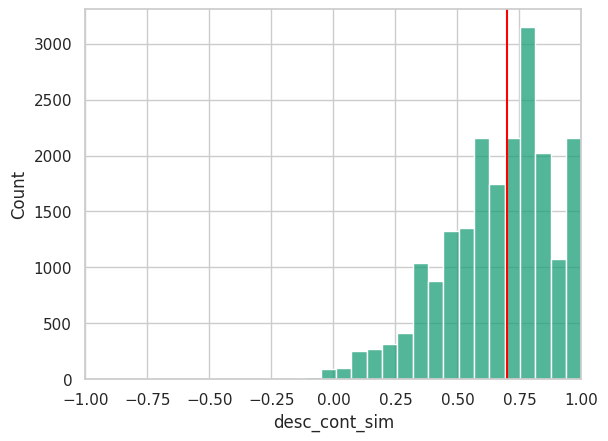

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data = df['desc_cont_sim'], bins=20)
plt.xlim(-1, 1)
xmedian = np.median(df['desc_cont_sim'])
plt.axvline(xmedian, color='red')

### Векторизация Tiny BERT

В качестве предобученной модели воспользуемся Tiny BERT – https://huggingface.co/sergeyzh/rubert-tiny-turbo

Она априори менее точная, чем базовый BERT, но строит эмбеддинги в разы быстрее.

In [ ]:
# загружаем модель из библиотеки huggingface

from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('sergeyzh/rubert-tiny-turbo')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/431k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

> Если вы выполняете эту лабораторную локально, то возможны конфликты версии `sentence_transformers` и `tensorflow`, обычно решающиеся даунгрейдом `tensorflow`.

Прежде чем формировать эмбеддинги, объединим список токенов в строку.

In [ ]:
# ваш код здесь
df['contents_str'] = df['contents_new'].apply(lambda x: ' '.join(x))
df['description_str'] = df['description_new'].apply(lambda x: ' '.join(x))
# пример результата преобразования
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,description_new,contents_embedding,description_embedding,desc_cont_sim,contents_str,description_str
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг]","[цель, курс, предоставить, возможность, магист...","[-0.9867507, 0.59560335, 0.2158096, -1.0835512...","[-0.69002604, 0.27199325, 0.082059555, -0.7921...",0.635177,инновационный маркетинг,цель курс предоставить возможность магистрант ...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составить, соответствие, требовани...","[-0.015672177, 0.46538958, -0.045063276, 0.198...","[-0.18337621, 0.32341155, 0.31151345, -0.46322...",0.215015,математический модель сигнал помеха канал связь,программа составить соответствие требование об...
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[дать, дисциплина, учить, планировать, меропри...","[-0.3442846, 0.7179183, 0.17016207, -0.6916874...","[-0.17791948, 0.39518368, 0.18778795, -0.18329...",0.794858,особенность организация массовый мероприятие п...,дать дисциплина учить планировать мероприятие ...


Чтобы не генерировать несколько раз одинаковые векторы (в данных много неуникальных описаний и содеражний), оставим только уникальные, а затем присоединим их в исходную таблицу. Уникальных записей в разрезе описания и содержания около 2500.

>`tqdm.auto` позволяет в удобном формате добавлять прогресс-бар к некоторым методам `pandas` – например, `apply`, и получать метод `progress_apply`.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()


bert_data = df[['contents_str', 'description_str']].drop_duplicates()
# Генерация уникальных векторов
bert_data['bert_content_embedding'] = bert_data['contents_str'].progress_apply(lambda x: bert_model.encode(x))
bert_data['bert_description_embedding'] = bert_data['description_str'].progress_apply(lambda x: bert_model.encode(x))



  0%|          | 0/2324 [00:00<?, ?it/s]

  0%|          | 0/2324 [00:00<?, ?it/s]

Теперь присоедините полученную таблицу в исходный датафрейм.

In [ ]:
# ваш код здесь
df = df.merge(bert_data, on=['description_str', 'contents_str'], how='left')
# пример результата объединения
print(df.shape)
df.sample(3, random_state=42)

(20502, 18)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,description_new,contents_embedding,description_embedding,desc_cont_sim,contents_str,description_str,bert_content_embedding,bert_description_embedding
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг]","[цель, курс, предоставить, возможность, магист...","[-0.9867507, 0.59560335, 0.2158096, -1.0835512...","[-0.69002604, 0.27199325, 0.082059555, -0.7921...",0.635177,инновационный маркетинг,цель курс предоставить возможность магистрант ...,"[0.0059510334, -0.044109605, 0.06990279, -0.03...","[0.011298621, -0.028861044, 0.02869689, 0.0134..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составить, соответствие, требовани...","[-0.015672177, 0.46538958, -0.045063276, 0.198...","[-0.18337621, 0.32341155, 0.31151345, -0.46322...",0.215015,математический модель сигнал помеха канал связь,программа составить соответствие требование об...,"[-0.03218018, -0.00448296, 0.09455557, -0.0244...","[0.014892081, -0.030183127, 0.022986414, -0.01..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[дать, дисциплина, учить, планировать, меропри...","[-0.3442846, 0.7179183, 0.17016207, -0.6916874...","[-0.17791948, 0.39518368, 0.18778795, -0.18329...",0.794858,особенность организация массовый мероприятие п...,дать дисциплина учить планировать мероприятие ...,"[0.051145438, 0.0004481963, 0.0001392925, -0.0...","[0.0043064496, -0.020332063, -0.0007721973, -0..."


In [ ]:
# размер вектора Tiny BERT – 312, что близко к размеру векторов w2v
df.bert_content_embedding[0].shape

(312,)

Повторим эксперимент из предыдущего раздела – оценим, насколько схожи векторы описания и содержания для одной дисциплины, сгенерированные BERT.

In [ ]:
df['bert_desc_cont_sim'] = df.apply(lambda x: cosine_similarity(x["bert_content_embedding"], x["bert_description_embedding"]), axis=1)

Постройте график. Вероятно, он будет похож на тот, что ниже.

Здесь снова пунктиром обозначена медиана.

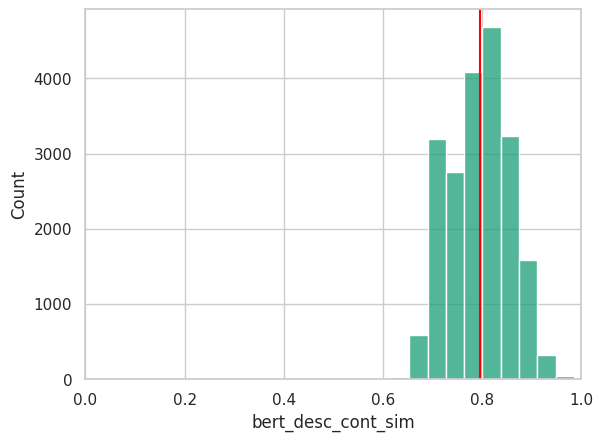

In [ ]:
sns.histplot(data = df['bert_desc_cont_sim'], bins=10)
plt.xlim(0, 1)
xmedian = np.median(df['bert_desc_cont_sim'])
plt.axvline(xmedian, color='red')

Теперь сравните распределения сходств, полученных при использовании разных подходов к векторизации.

В результате должно получиться нечто похожее на гистограмму ниже. По ней видно, что вектора Tiny BERT дают более узкий диапазон сходств. И более высокие значения. Это можно объяснить тем, что:
- модель обучалась на более широком контексте и не улавливает тонкостей разных дисциплин
- относительно стандартного BERT качество модели сильно ниже (его можно поизучать по ссылке в начале раздела)

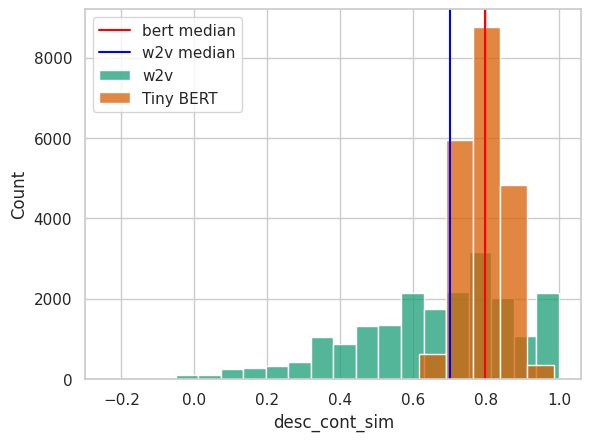

In [ ]:
sns.histplot(data = df['desc_cont_sim'], bins=20, label='w2v')
xmedian = np.median(df['desc_cont_sim'])
sns.histplot(data = df['bert_desc_cont_sim'], bins=5, label='Tiny BERT')
bert_xmedian = np.median(df['bert_desc_cont_sim'])
w2v_xmedian = np.median(df['desc_cont_sim'])
plt.axvline(bert_xmedian, color='red', label='bert median')
plt.axvline(w2v_xmedian, color='blue', label='w2v median')

plt.legend()

## Задача 2 – Сгенерировать description и contents

Задача 2 – исследовательская. Надо проверить, как с работой преподавателя справится большая языковая модель. В исходных данных расположены описания и темы из содержания, написанные реальными людьми. Теперь используем LLM для той же задачи. Также рассмотрим, как разные техники промпт-инжиниринга будут влиять на результат.

### Техники промпт-инжиниринга

Под техникой промпт-инжиниринга (или промптинга) понимается практика разработки и оптимизации промптов (запросов, подсказок) к модели, которые помогут получить максимально близкий к ожидаемому ответ и эффективно взаимодействовать с языковой моделью. Это ключевой элемент в управлении работой и поведением LLM.


Наиболее популярными являются следующие техники:
1. **Zero-shot** (Обучение без примеров) – модель применяет общие знания и правила для решения новых задач.
2. **Few-shot** (Обучение на нескольких примерах) – модель адаптируется к новым задачам, используя небольшой набор примеров.
3. **Chain-of-thought** (Цепочка рассуждений) – модель генерирует пошаговое рассуждение для решения задачи, что помогает в понимании сложных задач и улучшает точность ответов.
4. **Tree of thoughts** (Дерево рассуждений) – подход, при котором рассматриваются различные варианты решений или идей, ветвящиеся от основной мысли.

В этой работе воспользуемся первыми двумя подходами.

В колабе слишком мало ресурсов (если пользоваться бесплатной версией), чтобы хотя бы запустить какую-нибудь интересную современную модель через модуль `transformers`, и тем более ресурсов не хватит для дообучения. Поэтому для тестирования воспользуемся API/serverless API.

Тестировать запросы будем к LLM mistral-nemo-instruct-2407 – https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407

Это дообученная instruct-версия модели mistral-nemo-base-2407 (12В). Модели категории Instruct способны генерировать ответ, следуя заданному им шаблону поведения.

Обе версии (base и instruct) мультиязычные и выпущены MistralAI и NVIDIA в июле 2024.

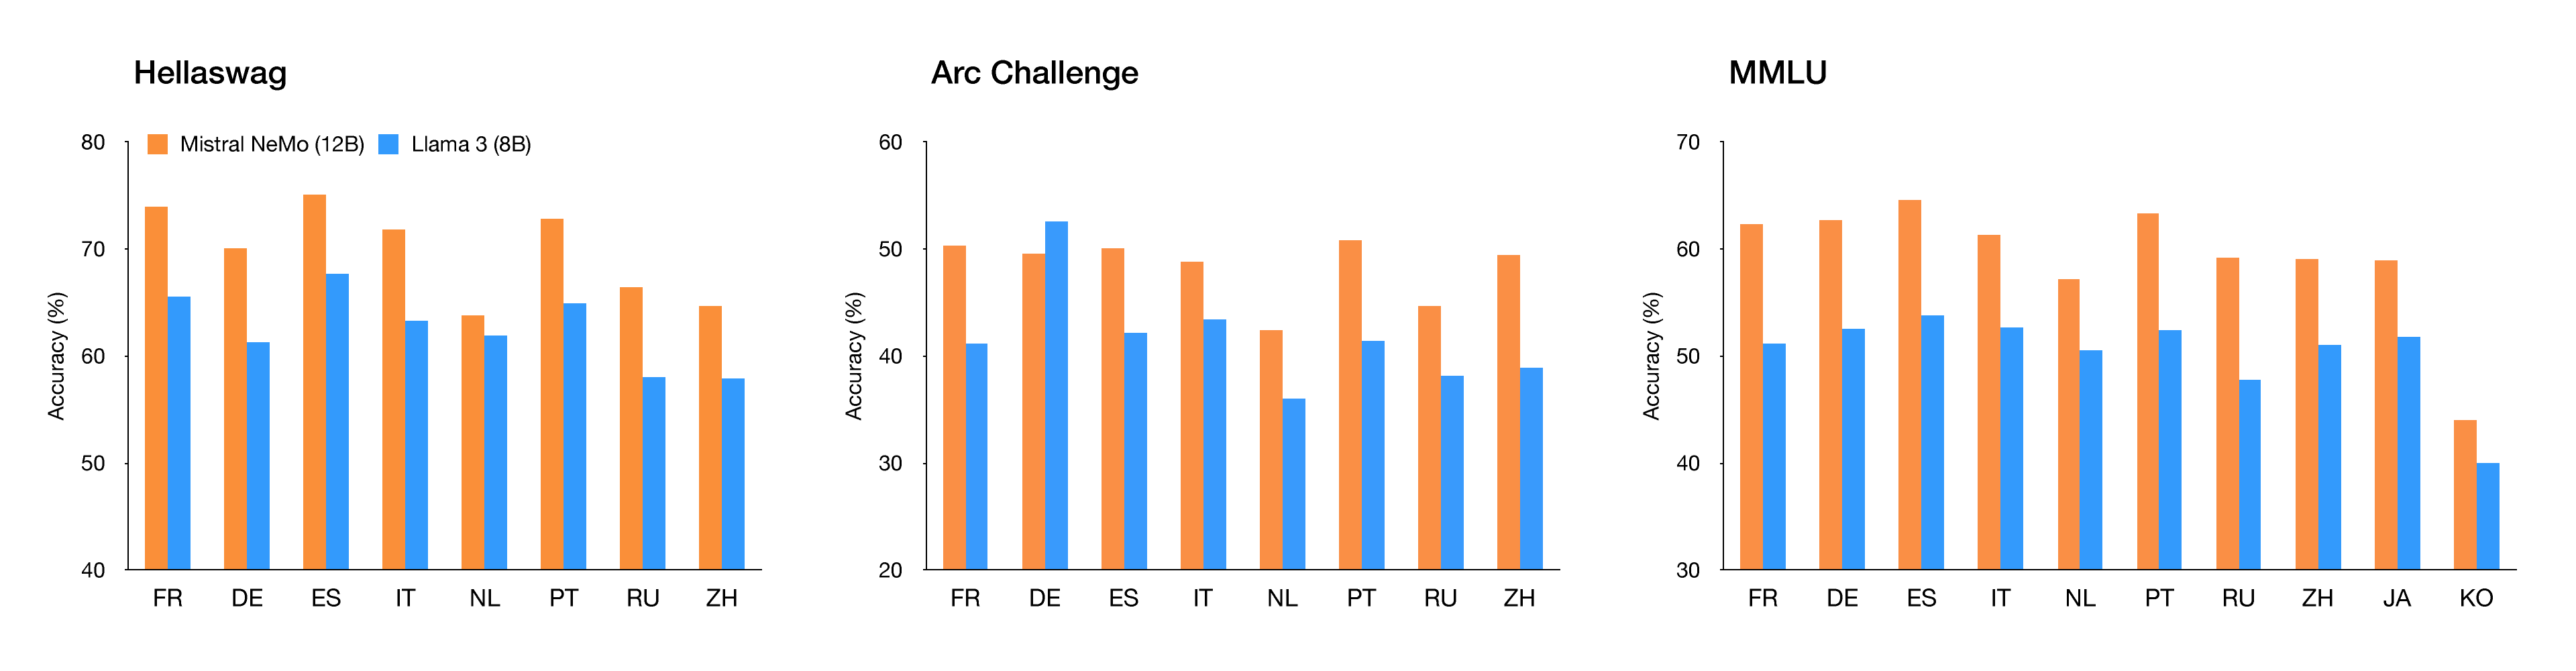

#### zero-shot

Техника промпт-инжиниринга, в которой мы, не давая модели никакой вспомогательной информации, ожидаем от нее ответа на запрос (промпт) в свободной форме.

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key="тут был токен)")  # ваш токен с  HuggingFace

Базово запустим модель через serverless API, предоставляемый HuggingFace. Это самый простой способо интегрировать модель в колаб. Для использования в реальных приложениях он не подойдет.

In [ ]:
messages = [
	{
		"role": "user",
		"content": """Ты – преподаватель в университете.
                  Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'.
                  Разделов должно быть не более 8."""
	}
]

completion = client.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
	  messages=messages,
	  max_tokens=500
)

print(completion.choices[0].message.content)

1. Введение в язык Python и его применение в анализе данных
2. Типы данных в Python и операторы
3. Структуры данных в Python: списки, кортежи, словари, множества
4. Управляющие конструкции: условные операторы, циклы, функции
5. Модули и пакеты Python для анализа данных: NumPy, Pandas, Matplotlib
6. Обletiра и предварительная обработка данных: чтение и запись файлов, работа с датами,Nellaage и кодирование данных
7. Математические операции с данными: статистические Funktionen, векторы и матрицы, линейная алгебра
8. Визуализация данных: графики и диаграммы с помощью Matplotlib и Seaborn.


Можно получить что-то адекватное, а можно – что-то такое🤣

>**Текст промпта имеет значение!**

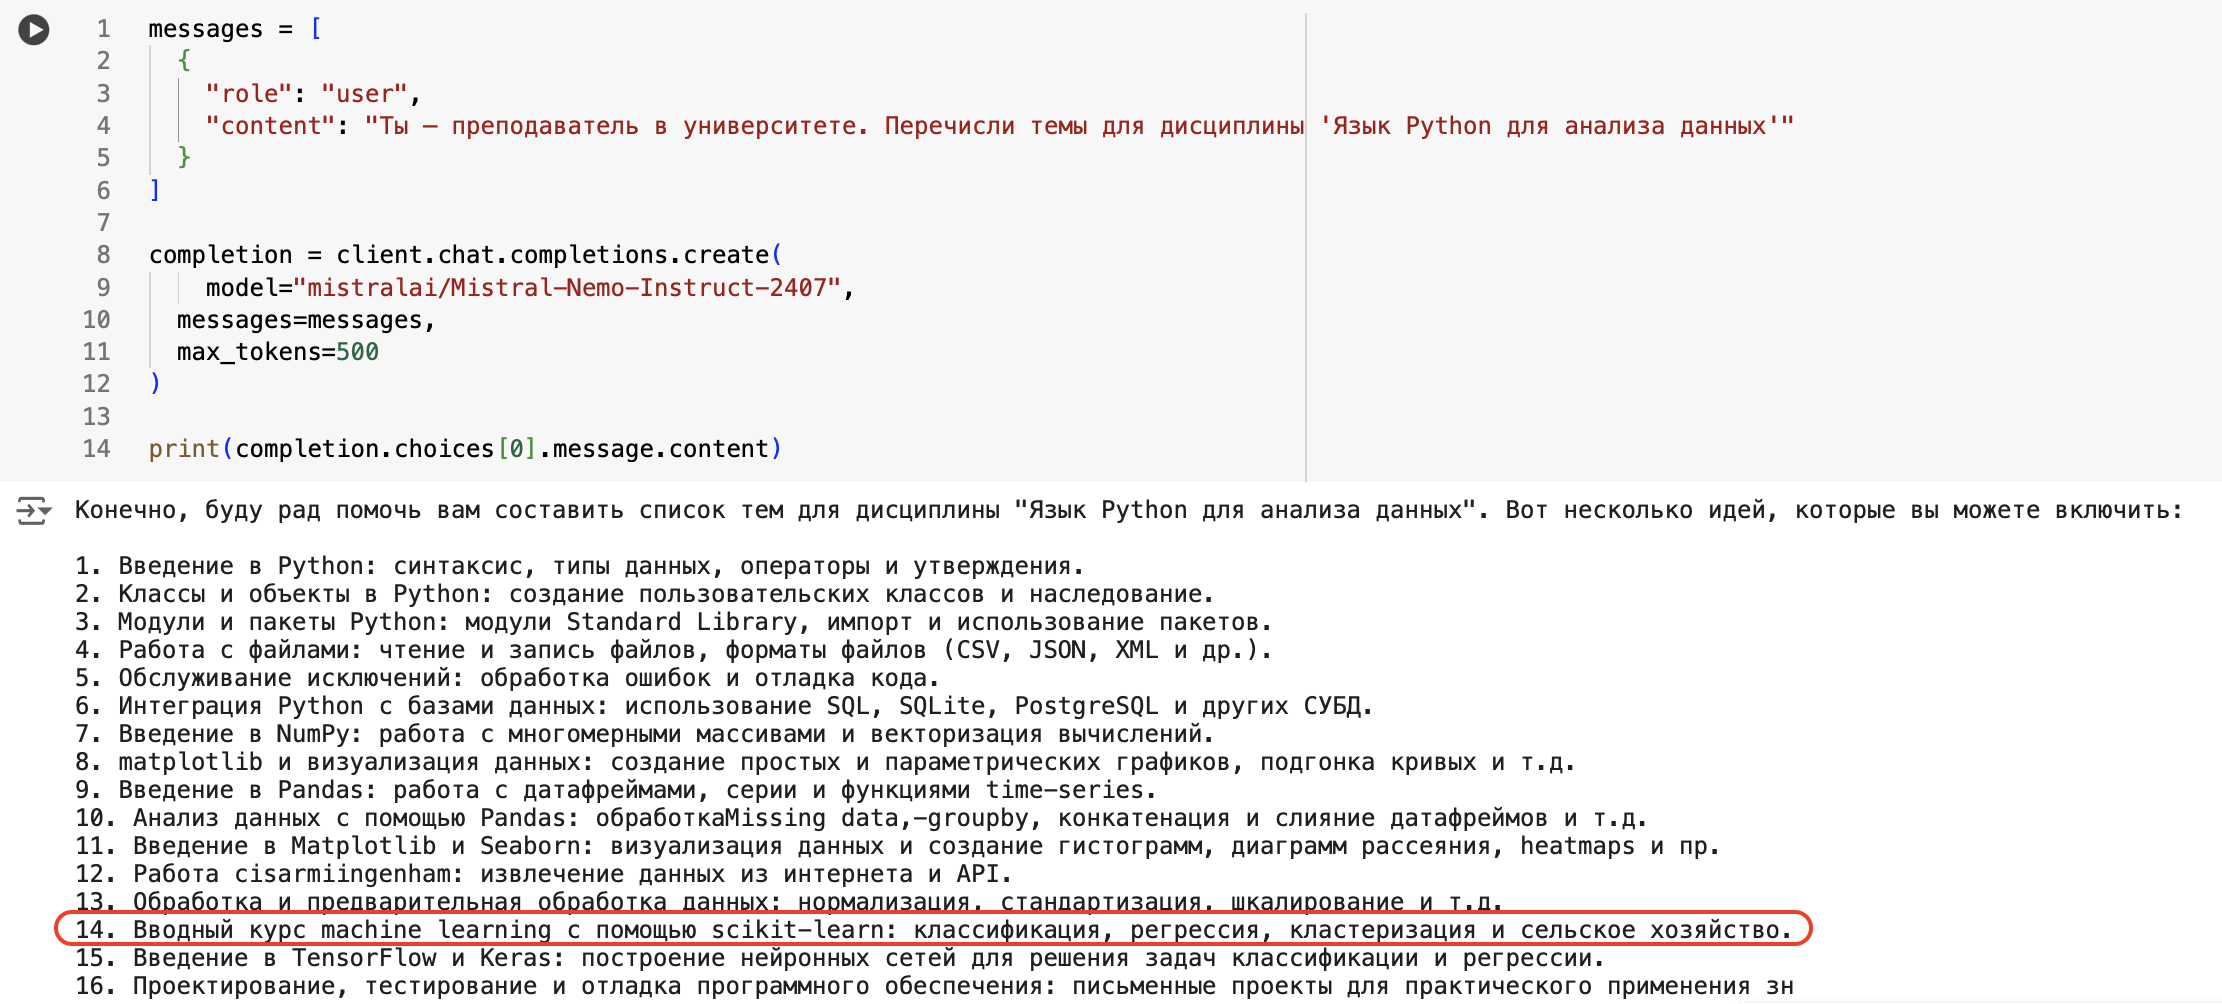

Но параметры API-запросов можно настраивать – https://huggingface.co/docs/api-inference/tasks/chat-completion

Наиболее ценные из них, сокращающие число галлюцинаций модели:
- temperature (температура): варьируется от 0 до 2 – чем выше, тем выше свобода модели в самовыражении и тем случайнее результат. До 0.5 считается низкой, но хорошо поэкспериментировать, чтобы подобрать наиболее адекватный для своей задачи результат.
- top_p – задает планку (долю), по которой отсекаются наименее релевантные ответы для вопроса, 0.1 означает, что для формирования ответа берутся 10% наиболее значимых токенов. Рекомендуется настраивать либо температуру, либо вероятность.

Поработаем с температурой. В качестве примера сгенерируем содержание дисциплины "Язык Python для анализа данных" с температурой от 0 до 2 с шагом 0.1.

In [ ]:
import numpy as np

messages = [
	{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'. Разделов должно быть не более 8."
	}
]

temperatures = np.arange(0,2,0.1)

for temp in temperatures:
    print(f"\n{'*'*20} temperature = {temp} {'*'*20}\n")

    completion = client.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    print(completion.choices[0].message.content)



******************** temperature = 0.0 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа с пакетами, виртуальные окружения.
3. Работа с файлами: чтение и запись файлов, работа с директориями, исключения при работе с файлами.
4. Коллекции данных: списки, кортежи, словари, множества, работа с коллекциями.
5. Функции высшего порядка: map, filter, reduce, lambda-функции, декораторы.
6. Объектно-ориентированное программирование: классы, объекты, наследование, полиморфизм, инкапсуляция.
7. Работа с датами и временем: модуль datetime, форматирование дат и времени.
8. Введение в NumPy и Pandas: работа с многомерными массивами, сериалами, датафреймами, визуализация данных.

******************** temperature = 0.1 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа 

Вывод: если температуру выкрутить на максимум, концентрация бреда зашкаливает, перемешиваются языки, генерируютя несуществующие слова; а если занулить, то ответ получается похожий на правду, но очень ограниченный и сухой.
>**Нужно искать такое значение температуры, при котором будет соблюдаться баланс между честностью и свободой творчества.**

В примере выше наиболее интересные результаты получились при температуре от 0.3 до 0.7. Результат на 0.7 наиболее творческий и обширный. В таком примере стоит потестировать несколько температур и повалидировать их генерации.

Попробуем еще пару примеров с другими дисциплинами.

In [ ]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,1,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Машинное обучение. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Современные инструменты для анализа данных. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Методы визуализации данных. Разделов должно быть не более 8.'}]]

******************** Машинное обучение: temperature = 0.3 ********************

1. Введение в машинное обучение: определение, история и области применения.
2. Математические основы машинного обучения: линейная алгебра, теория вероятностей и статистика.
3. Алгоритмы обучения с учителем: линейная регрессия, логистическая регрессия, деревья решений, случайные леса и другие алгоритмы градиентного спуска.
4. Алгоритмы обучения без учителя: кластеризация, ассоциативное правило, выяв

Здесь наиболее интересные ответы получаются при температуре 0.5–0.7. 0.7 ни в одном примере пока не ушли в откровенные галлюцинации.

Теперь сгенерируем содержание для 100 случайных дисциплин. Не будем брать все с целью экономии времени. Если есть время и желание, можно для всех 1757.

In [ ]:
ud = df[["course_title"]].drop_duplicates().sample(100, random_state=42)
ud.shape

(100, 1)

Напишите функцию `mistral_zero_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Альтернативно промпт можно тоже сделать параметром.

In [ ]:
def mistral_zero_shot(course, cli, temp, prompt):
    message = [
      {
        "role": "user",
        "content": prompt
      }
    ]

    completion = cli.chat.completions.create(
      model="mistralai/Mistral-Nemo-Instruct-2407",
      messages=message,
      max_tokens=500,
      temperature=temp
    )

    return completion.choices[0].message.content

Добавьте столбец со сгенерированным содержанием в датафрейм.

In [ ]:
prompt = "Сгенерируй содержание для дисциплины {}."

ud['mistral_contents'] = ud['course_title'].progress_apply(lambda x: mistral_zero_shot(x, client, 0.7, prompt.format(x)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# ваш код здесь
ud_df = df.merge(ud, on = ['course_title'], how='inner')
# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(1046, 20)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,description_new,contents_embedding,description_embedding,desc_cont_sim,contents_str,description_str,bert_content_embedding,bert_description_embedding,bert_desc_cont_sim,mistral_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]","[такой, фотоник]","[0.24171433, 0.35219103, 0.08809751, -0.154097...","[-0.17018557, 0.59243757, 0.46008384, -0.12257...",0.674982,введение метод численный электродинамика,такой фотоник,"[-0.07327735, 0.0034980702, 0.041691046, -0.08...","[0.019824592, -0.01338872, 0.022665022, 0.0036...",0.750936,Моделирование оптических процессов — это компл...
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...","[представить, начало, термодинамика, метод, ра...","[-0.084658384, 0.25797614, 0.013420078, -0.254...","[0.04741567, 0.23640028, 0.17817606, 0.0304193...",0.702330,подобие моделирование процесс конвективный теп...,представить начало термодинамика метод расчёт ...,"[-0.012101324, -0.00025984205, 0.042308394, -0...","[-0.0033381118, -0.009869828, 0.019813318, -0....",0.833161,Техническая термодинамика и теплопередача - эт...
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...","[основный, задача, данный, курс, предложить, р...","[0.20422648, -0.21405311, 0.045983475, 0.21268...","[-0.27613932, 0.3387492, 0.52174795, -0.843554...",0.108618,библиотека архив энциклопедия история big data,основный задача данный курс предложить различн...,"[0.015088565, 0.031201294, 0.038127735, -0.024...","[-0.021535553, -0.0014101948, 0.08410464, -0.0...",0.696861,Культурные подходы к цифровым практикам - это ...


Векторизуйте сгенерированное содержание с помощью обоих векторайзеров из предыдущего задания.

In [ ]:
ud_df['mistral_contents_new'] = ud_df['mistral_contents'].apply(lambda x: text_to_sentences(x, tokenizer)[0])
ud_df['mistral_contents_w2v_embedding'] = ud_df['mistral_contents_new'].apply(lambda x: embed(x, w2v_model))
ud_df['mistral_contents_str'] = ud_df['mistral_contents_new'].apply(lambda x: ' '.join(x))
ud_df['mistral_contents_bert_embedding'] = ud_df['mistral_contents_str'].apply(lambda x: bert_model.encode(x))

In [ ]:
# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,...,contents_str,description_str,bert_content_embedding,bert_description_embedding,bert_desc_cont_sim,mistral_contents,mistral_contents_new,mistral_contents_w2v_embedding,mistral_contents_str,mistral_contents_bert_embedding
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]",...,введение метод численный электродинамика,такой фотоник,"[-0.07327735, 0.0034980702, 0.041691046, -0.08...","[0.019824592, -0.01338872, 0.022665022, 0.0036...",0.750936,Моделирование оптических процессов — это компл...,"[моделирование, оптический, процесс, это, комп...","[0.038722336, 0.3397678, 0.018354623, -0.18976...",моделирование оптический процесс это комплексн...,"[0.0029188222, 0.028586503, 0.061244592, -0.01..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,подобие моделирование процесс конвективный теп...,представить начало термодинамика метод расчёт ...,"[-0.012101324, -0.00025984205, 0.042308394, -0...","[-0.0033381118, -0.009869828, 0.019813318, -0....",0.833161,Техническая термодинамика и теплопередача - эт...,"[технический, термодинамика, теплопередача, эт...","[0.037864786, 0.25192222, 0.24676844, 0.108287...",технический термодинамика теплопередача это ди...,"[0.007677965, -0.012635421, 0.01079873, -0.042..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,библиотека архив энциклопедия история big data,основный задача данный курс предложить различн...,"[0.015088565, 0.031201294, 0.038127735, -0.024...","[-0.021535553, -0.0014101948, 0.08410464, -0.0...",0.696861,Культурные подходы к цифровым практикам - это ...,"[культурный, подход, цифровой, практика, это, ...","[-0.3878519893269581, 0.19052848385889892, 0.3...",культурный подход цифровой практика это интерд...,"[0.007720647, -0.02944697, 0.06175957, -0.0145..."


Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

In [ ]:
ud_df["desc_cont_sim_mistral_w2v_contents"] = ud_df.apply(lambda x: cosine_similarity(x["contents_embedding"], x["mistral_contents_w2v_embedding"]), axis=1)
ud_df["desc_cont_sim_mistral_bert_contents"] = ud_df.apply(lambda x: cosine_similarity(x["bert_content_embedding"], x["mistral_contents_bert_embedding"]), axis=1)

ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,...,bert_content_embedding,bert_description_embedding,bert_desc_cont_sim,mistral_contents,mistral_contents_new,mistral_contents_w2v_embedding,mistral_contents_str,mistral_contents_bert_embedding,desc_cont_sim_mistral_w2v_contents,desc_cont_sim_mistral_bert_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]",...,"[-0.07327735, 0.0034980702, 0.041691046, -0.08...","[0.019824592, -0.01338872, 0.022665022, 0.0036...",0.750936,Моделирование оптических процессов — это компл...,"[моделирование, оптический, процесс, это, комп...","[0.038722336, 0.3397678, 0.018354623, -0.18976...",моделирование оптический процесс это комплексн...,"[0.0029188222, 0.028586503, 0.061244592, -0.01...",0.630803,0.765625
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,"[-0.012101324, -0.00025984205, 0.042308394, -0...","[-0.0033381118, -0.009869828, 0.019813318, -0....",0.833161,Техническая термодинамика и теплопередача - эт...,"[технический, термодинамика, теплопередача, эт...","[0.037864786, 0.25192222, 0.24676844, 0.108287...",технический термодинамика теплопередача это ди...,"[0.007677965, -0.012635421, 0.01079873, -0.042...",0.739577,0.824891
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,"[0.015088565, 0.031201294, 0.038127735, -0.024...","[-0.021535553, -0.0014101948, 0.08410464, -0.0...",0.696861,Культурные подходы к цифровым практикам - это ...,"[культурный, подход, цифровой, практика, это, ...","[-0.3878519893269581, 0.19052848385889892, 0.3...",культурный подход цифровой практика это интерд...,"[0.007720647, -0.02944697, 0.06175957, -0.0145...",0.143144,0.679736


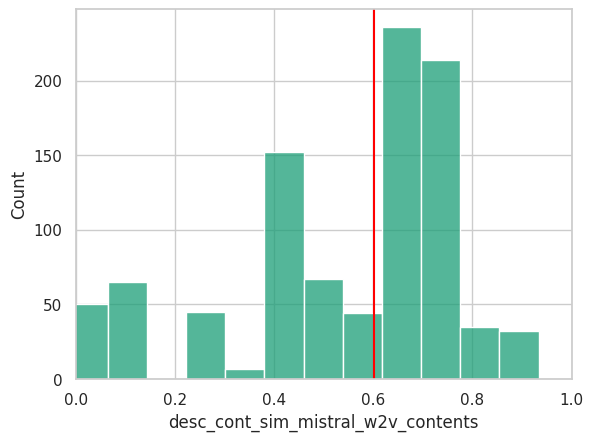

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_w2v_contents'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_w2v_contents'])
plt.axvline(xmedian, color='red')

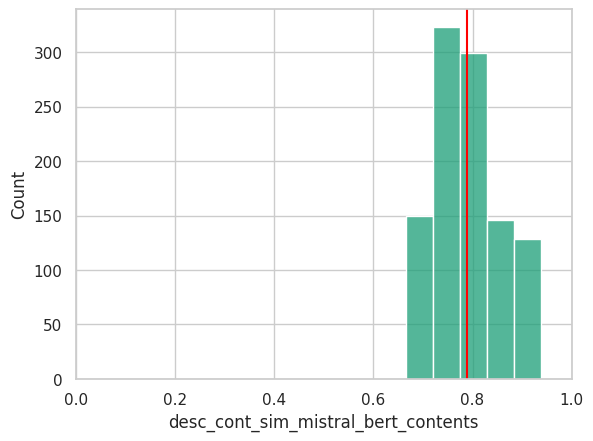

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_bert_contents'], bins=5)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_bert_contents'])
plt.axvline(xmedian, color='red')


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `zero-shot`.

In [ ]:
prompt = "Сгенерируй описание для дисциплины {}."

ud['mistral_description'] = ud['course_title'].progress_apply(lambda x: mistral_zero_shot(x, client, 0.7, prompt.format(x)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(1046, 26)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,...,bert_content_embedding,bert_description_embedding,bert_desc_cont_sim,mistral_contents,mistral_contents_new,mistral_contents_w2v_embedding,mistral_contents_str,mistral_contents_bert_embedding,desc_cont_sim_mistral_w2v_contents,desc_cont_sim_mistral_bert_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]",...,"[-0.07327735, 0.0034980702, 0.041691046, -0.08...","[0.019824592, -0.01338872, 0.022665022, 0.0036...",0.750936,Моделирование оптических процессов — это компл...,"[моделирование, оптический, процесс, это, комп...","[0.038722336, 0.3397678, 0.018354623, -0.18976...",моделирование оптический процесс это комплексн...,"[0.0029188222, 0.028586503, 0.061244592, -0.01...",0.630803,0.765625
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,"[-0.012101324, -0.00025984205, 0.042308394, -0...","[-0.0033381118, -0.009869828, 0.019813318, -0....",0.833161,Техническая термодинамика и теплопередача - эт...,"[технический, термодинамика, теплопередача, эт...","[0.037864786, 0.25192222, 0.24676844, 0.108287...",технический термодинамика теплопередача это ди...,"[0.007677965, -0.012635421, 0.01079873, -0.042...",0.739577,0.824891
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,"[0.015088565, 0.031201294, 0.038127735, -0.024...","[-0.021535553, -0.0014101948, 0.08410464, -0.0...",0.696861,Культурные подходы к цифровым практикам - это ...,"[культурный, подход, цифровой, практика, это, ...","[-0.3878519893269581, 0.19052848385889892, 0.3...",культурный подход цифровой практика это интерд...,"[0.007720647, -0.02944697, 0.06175957, -0.0145...",0.143144,0.679736


In [ ]:
ud_df.columns

Index(['course_id', 'course_title', 'description', 'up_id', 'up_title',
       'qualification', 'start_year', 'module_name', 'contents',
       'contents_new', 'description_new', 'contents_embedding',
       'description_embedding', 'desc_cont_sim', 'contents_str',
       'description_str', 'bert_content_embedding',
       'bert_description_embedding', 'bert_desc_cont_sim', 'mistral_contents',
       'mistral_contents_new', 'mistral_contents_w2v_embedding',
       'mistral_contents_str', 'mistral_contents_bert_embedding',
       'desc_cont_sim_mistral_w2v_contents',
       'desc_cont_sim_mistral_bert_contents'],
      dtype='object')

In [ ]:
ud_df = ud_df.merge(ud, on=['mistral_contents'], how='left')

In [ ]:
ud_df['mistral_description_new'] = ud_df['mistral_description'].apply(lambda x: text_to_sentences(x, tokenizer)[0])
ud_df['mistral_description_w2v_embedding'] = ud_df['mistral_description_new'].apply(lambda x: embed(x, w2v_model))
ud_df['mistral_description_str'] = ud_df['mistral_description_new'].apply(lambda x: ' '.join(x))
ud_df['mistral_description_bert_embedding'] = ud_df['mistral_description_str'].apply(lambda x: bert_model.encode(x))

In [ ]:
# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title_x,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,...,mistral_contents_str,mistral_contents_bert_embedding,desc_cont_sim_mistral_w2v_contents,desc_cont_sim_mistral_bert_contents,course_title_y,mistral_description,mistral_description_new,mistral_description_w2v_embedding,mistral_description_str,mistral_description_bert_embedding
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]",...,моделирование оптический процесс это комплексн...,"[0.0029188222, 0.028586503, 0.061244592, -0.01...",0.630803,0.765625,Моделирование оптических процессов,"Дисциплина ""Моделирование оптических процессов...","[дисциплина, моделирование, оптический, процес...","[-0.13988435, 0.3402686, 0.0602241, -0.1982224...",дисциплина моделирование оптический процесс пр...,"[0.038013652, 0.020712996, 0.070450336, -0.015..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,технический термодинамика теплопередача это ди...,"[0.007677965, -0.012635421, 0.01079873, -0.042...",0.739577,0.824891,Техническая термодинамика и теплопередача,Техническая термодинамика и теплопередача - эт...,"[технический, термодинамика, теплопередача, эт...","[-0.0007683984, 0.32640073, 0.25421518, -0.025...",технический термодинамика теплопередача это ди...,"[0.018069895, -0.009931375, 0.026263522, -0.04..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,культурный подход цифровой практика это интерд...,"[0.007720647, -0.02944697, 0.06175957, -0.0145...",0.143144,0.679736,Культурные подходы к цифровым практикам,"Дисциплина ""Культурные подходы к цифровым прак...","[дисциплина, культурный, подход, цифровой, пра...","[-0.2627563, 0.3547473, 0.21753618, -0.3393535...",дисциплина культурный подход цифровой практика...,"[-0.0060377745, -0.02316254, 0.061440807, -0.0..."


In [ ]:
ud_df["desc_cont_sim_mistral_w2v_description"] = ud_df.apply(lambda x: cosine_similarity(x["description_embedding"], x["mistral_description_w2v_embedding"]), axis=1)
ud_df["desc_cont_sim_mistral_bert_description"] = ud_df.apply(lambda x: cosine_similarity(x["bert_description_embedding"], x["mistral_description_bert_embedding"]), axis=1)

ud_df.sample(3, random_state=42)

,course_id,course_title_x,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,...,desc_cont_sim_mistral_w2v_contents,desc_cont_sim_mistral_bert_contents,course_title_y,mistral_description,mistral_description_new,mistral_description_w2v_embedding,mistral_description_str,mistral_description_bert_embedding,desc_cont_sim_mistral_w2v_description,desc_cont_sim_mistral_bert_description
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]",...,0.630803,0.765625,Моделирование оптических процессов,"Дисциплина ""Моделирование оптических процессов...","[дисциплина, моделирование, оптический, процес...","[-0.13988435, 0.3402686, 0.0602241, -0.1982224...",дисциплина моделирование оптический процесс пр...,"[0.038013652, 0.020712996, 0.070450336, -0.015...",0.723364,0.703145
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,0.739577,0.824891,Техническая термодинамика и теплопередача,Техническая термодинамика и теплопередача - эт...,"[технический, термодинамика, теплопередача, эт...","[-0.0007683984, 0.32640073, 0.25421518, -0.025...",технический термодинамика теплопередача это ди...,"[0.018069895, -0.009931375, 0.026263522, -0.04...",0.779134,0.850138
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,0.143144,0.679736,Культурные подходы к цифровым практикам,"Дисциплина ""Культурные подходы к цифровым прак...","[дисциплина, культурный, подход, цифровой, пра...","[-0.2627563, 0.3547473, 0.21753618, -0.3393535...",дисциплина культурный подход цифровой практика...,"[-0.0060377745, -0.02316254, 0.061440807, -0.0...",0.810961,0.831786


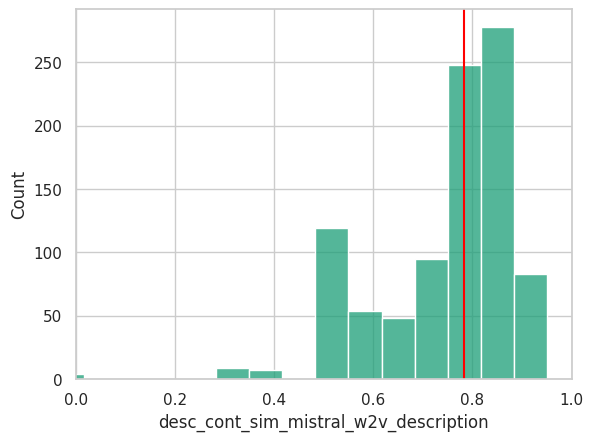

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_w2v_description'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_w2v_description'])
plt.axvline(xmedian, color='red')

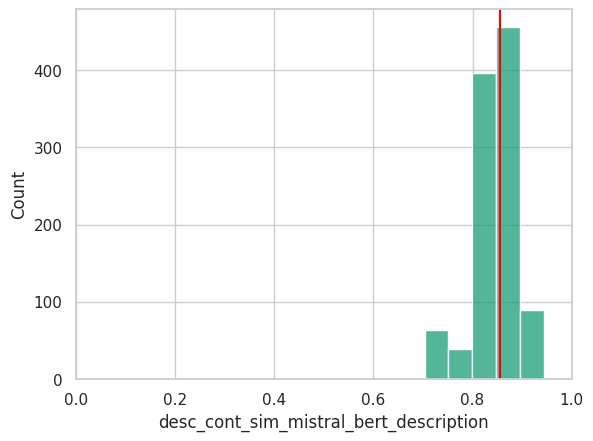

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_bert_description'], bins=5)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_bert_description'])
plt.axvline(xmedian, color='red')

#### few-shot

Как следует из названия техники, few-shot подразумевает, что мы даем модели несколько примеров, по которым она должна понять, в каком формате (и/или какого рода информацию) мы ожидаем получить в ответ на запрос. Эти примеры подаются как часть промпта. Можно также встретить понятия one-shot (один пример), two-shot (два примера) и т.д. Это частные случаи few-shot.

Попробуем развить предыдущий пример, используя как эталонный вариант ответа результат при температуре 0.7 для дисциплины "Язык Python для анализа данных".

In [ ]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": """Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8."""
.format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,0.8,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.\nОтвет:\n   Тема 1: Введение в Python для анализа данных\n- Обзор Python и его применения в анализе данных\n- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)\n- Основы синтаксиса Python\n\nТема 2: Основы анализа данных\n- Типы данных и структуры данных в Python\n- Обработка и очистка данных\n- Работа с большими данными\n\nТема 3: Анализ данных с помощью NumPy\n- Введение в NumPy\n- Массивы и векторы\n- Операции над массивами\n- Функции и методы NumPy\n\nТема 4: Анализ данных с помощью Pandas\n- Введение в Pandas\n- Сериалы и ДатаФреймы\n- Обработка и манипулирование данными\n- Агрегация и групповые операции\n\nТема 5: Визуализация данных с помощью Matplotlib и Seaborn\n- Введение в Matplotlib\n- Создание простых графиков\n- Настройка стиля и темы\n- Введение в Seaborn\n\nТем

Если показывать модели пример запроса и эталонный ответ, то наиболее близкие к правде ответы получаются при самых низких температурах. Возможно, ниже 0.3 было бы еще грамотнее. Зато при более высоких модели не хватает токенов и появляется много подробностей, которые, возможно, излишни.

Напишите функцию `mistral_one_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Аналогично предыдущему разделу, сгенерируйте содержание для выбранных 100 дисциплин (или всех). Затем предобработайте данные и проведите векторизацию обоими векторайзерами.

In [ ]:
def mistral_one_shot(course, cli, temp, prompt):
    message = [
      {
        "role": "user",
        "content": prompt
      }
    ]

    completion = cli.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
    )

    return completion.choices[0].message.content

In [ ]:
prompt = """Запрос: Ты – преподаватель в университете. Напиши содержание для дисциплины Язык Python для анализа данных.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Напиши содержание для дисциплины {}."""


ud['mistral_one_shot_contents'] = ud['course_title'].progress_apply(lambda x: mistral_one_shot(x, client, 0.5, prompt.format(x)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
ud_df = ud_df.merge(ud, on=['mistral_contents'], how='left')

In [ ]:
ud_df['one_shot_contents_new'] = ud_df['mistral_one_shot_contents'].apply(lambda x: text_to_sentences(x, tokenizer)[0])
ud_df['one_shot_contents_w2v_embedding'] = ud_df['one_shot_contents_new'].apply(lambda x: embed(x, w2v_model))
ud_df['one_shot_contents_str'] = ud_df['one_shot_contents_new'].apply(lambda x: ' '.join(x))
ud_df['one_shot_contents_bert_embedding'] = ud_df['one_shot_contents_str'].apply(lambda x: bert_model.encode(x))

In [ ]:
ud_df["desc_cont_sim_one_shot_w2v_contents"] = ud_df.apply(lambda x: cosine_similarity(x["contents_embedding"], x["one_shot_contents_w2v_embedding"]), axis=1)
ud_df["desc_cont_sim_one_shot_bert_contents"] = ud_df.apply(lambda x: cosine_similarity(x["bert_content_embedding"], x["one_shot_contents_bert_embedding"]), axis=1)

ud_df.sample(3, random_state=42)

,course_id,course_title_x,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,...,desc_cont_sim_mistral_bert_description,course_title,mistral_description_y,mistral_one_shot_contents,one_shot_contents_new,one_shot_contents_w2v_embedding,one_shot_contents_str,one_shot_contents_bert_embedding,desc_cont_sim_one_shot_w2v_contents,desc_cont_sim_one_shot_bert_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]",...,0.703145,Моделирование оптических процессов,"Дисциплина ""Моделирование оптических процессов...",Тема 1: Введение в моделирование оптических пр...,"[тема, введение, моделирование, оптический, пр...","[0.0422174170366086, 0.4537136986403278, 0.002...",тема введение моделирование оптический процесс...,"[-0.0059902826, 0.029093485, 0.03709298, -0.01...",0.760164,0.728896
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,0.850138,Техническая термодинамика и теплопередача,Техническая термодинамика и теплопередача - эт...,Тема 1: Введение в техническую термодинамику\n...,"[тема, введение, технический, термодинамика, о...","[0.05217782016552519, 0.2345716474155779, 0.20...",тема введение технический термодинамика основн...,"[-0.00076605834, -0.00621133, 0.02147134, -0.0...",0.715947,0.791035
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,0.831786,Культурные подходы к цифровым практикам,"Дисциплина ""Культурные подходы к цифровым прак...",Тема 1: Введение в цифровые практики и культур...,"[тема, введение, цифровой, практика, культурны...","[-0.13247174232012845, 0.1172779618193292, 0.1...",тема введение цифровой практика культурный под...,"[-0.0055060503, -0.022571763, 0.06733968, 0.01...",0.213184,0.626939


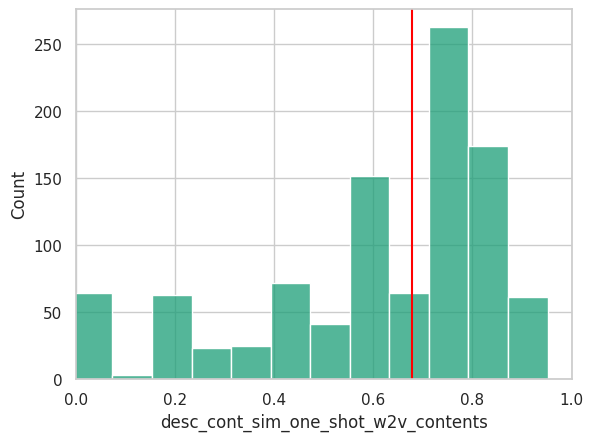

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_w2v_contents'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_w2v_contents'])
plt.axvline(xmedian, color='red')

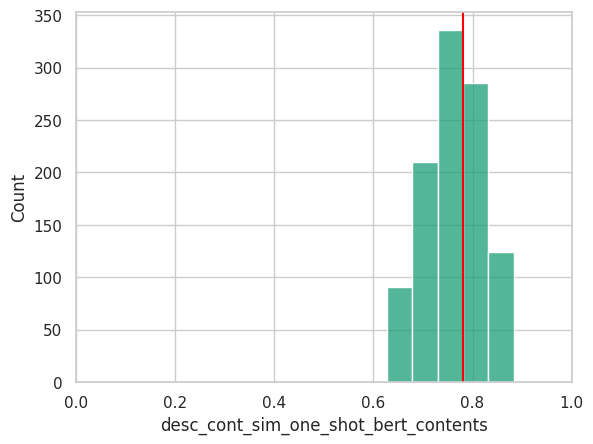

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_bert_contents'], bins=5)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_bert_contents'])
plt.axvline(xmedian, color='red')


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `few-shot`.

In [ ]:
prompt = """Запрос: Ты – преподаватель в университете. Напиши описание для дисциплины Язык Python для анализа данных.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Напиши содержание для дисциплины {}."""


ud['mistral_one_shot_description'] = ud['course_title'].progress_apply(lambda x: mistral_one_shot(x, client, 0.5, prompt.format(x)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
ud.columns

Index(['course_title', 'mistral_contents', 'mistral_description',
       'mistral_one_shot_contents', 'mistral_one_shot_description'],
      dtype='object')

In [ ]:
ud_df.columns

Index(['course_id', 'course_title_x', 'description', 'up_id', 'up_title',
       'qualification', 'start_year', 'module_name', 'contents',
       'contents_new', 'description_new', 'contents_embedding',
       'description_embedding', 'desc_cont_sim', 'contents_str',
       'description_str', 'bert_content_embedding',
       'bert_description_embedding', 'bert_desc_cont_sim', 'mistral_contents',
       'mistral_contents_new', 'mistral_contents_w2v_embedding',
       'mistral_contents_str', 'mistral_contents_bert_embedding',
       'desc_cont_sim_mistral_w2v_contents',
       'desc_cont_sim_mistral_bert_contents', 'course_title_y',
       'mistral_description_x', 'mistral_description_new',
       'mistral_description_w2v_embedding', 'mistral_description_str',
       'mistral_description_bert_embedding',
       'desc_cont_sim_mistral_w2v_description',
       'desc_cont_sim_mistral_bert_description', 'course_title',
       'mistral_description_y', 'mistral_one_shot_contents',
       'one_

In [ ]:
ud_df = ud_df.merge(ud, on='course_title', how='left')

In [ ]:
ud_df['one_shot_description_new'] = ud_df['mistral_one_shot_description'].apply(lambda x: text_to_sentences(x, tokenizer)[0])
ud_df['one_shot_description_w2v_embedding'] = ud_df['one_shot_description_new'].apply(lambda x: embed(x, w2v_model))
ud_df['one_shot_description_str'] = ud_df['one_shot_description_new'].apply(lambda x: ' '.join(x))
ud_df['one_shot_description_bert_embedding'] = ud_df['one_shot_description_str'].apply(lambda x: bert_model.encode(x))

In [ ]:
ud_df["desc_cont_sim_one_shot_w2v_description"] = ud_df.apply(lambda x: cosine_similarity(x["description_embedding"], x["one_shot_description_w2v_embedding"]), axis=1)
ud_df["desc_cont_sim_one_shot_bert_description"] = ud_df.apply(lambda x: cosine_similarity(x["bert_description_embedding"], x["one_shot_description_bert_embedding"]), axis=1)

ud_df.sample(3, random_state=42)

,course_id,course_title_x,description,up_id,up_title,qualification,start_year,module_name,contents,contents_new,...,mistral_contents_y,mistral_description,mistral_one_shot_contents_y,mistral_one_shot_description,one_shot_description_new,one_shot_description_w2v_embedding,one_shot_description_str,one_shot_description_bert_embedding,desc_cont_sim_one_shot_w2v_description,desc_cont_sim_one_shot_bert_description
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика]",...,Моделирование оптических процессов — это компл...,"Дисциплина ""Моделирование оптических процессов...",Тема 1: Введение в моделирование оптических пр...,Тема 1: Введение в моделирование оптических пр...,"[тема, введение, моделирование, оптический, пр...","[0.10232514918179196, 0.3713464311714394, 0.04...",тема введение моделирование оптический процесс...,"[-0.022150077, 0.024356829, 0.0334116, -0.0094...",0.627250,0.661486
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,Техническая термодинамика и теплопередача - эт...,Техническая термодинамика и теплопередача - эт...,Тема 1: Введение в техническую термодинамику\n...,Тема 1: Введение в техническую термодинамику\n...,"[тема, введение, технический, термодинамика, о...","[0.030995260320196394, 0.1843301105327555, 0.1...",тема введение технический термодинамика обзор ...,"[-0.0059426147, -0.0035666786, 0.023769526, -0...",0.871467,0.860373
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,Культурные подходы к цифровым практикам - это ...,"Дисциплина ""Культурные подходы к цифровым прак...",Тема 1: Введение в цифровые практики и культур...,"Дисциплина ""Культурные подходы к цифровым прак...","[дисциплина, культурный, подход, цифровой, пра...","[-0.16795402098643153, 0.21661363522473134, 0....",дисциплина культурный подход цифровой практика...,"[0.010832377, -0.033226635, 0.073261626, -0.01...",0.787003,0.833129


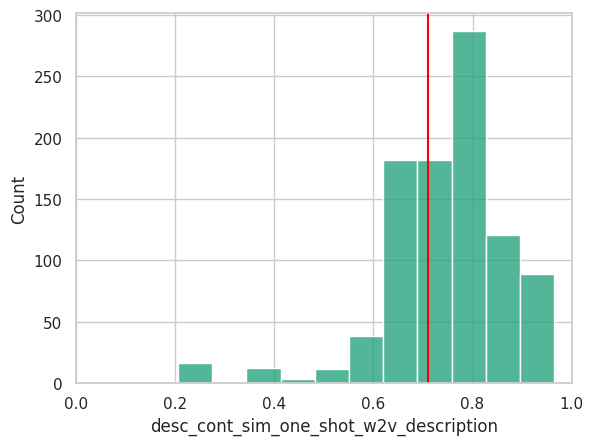

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_w2v_description'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_w2v_description'])
plt.axvline(xmedian, color='red')

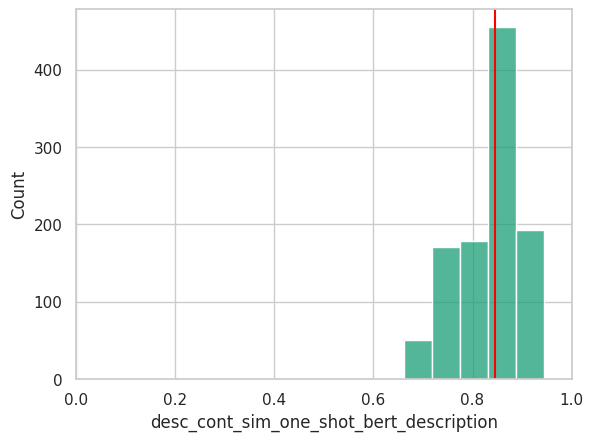

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_bert_description'], bins=5)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_bert_description'])
plt.axvline(xmedian, color='red')

## Задача 3 – Проанализировать результаты

Постройте визуализации для оценки результатов генерации искусственных данных по дисциплинам. В каждом пункте оценивайте результаты генерации в обеих техниках. Для каждого пункта напишите краткий вывод.

1. Постройте гистограмму, показывающую распределения сходств краткого описания с эталонным (человеческим) и содержания. Сравните результаты для обоих векторайзеров.

Содержание:

zero-shot

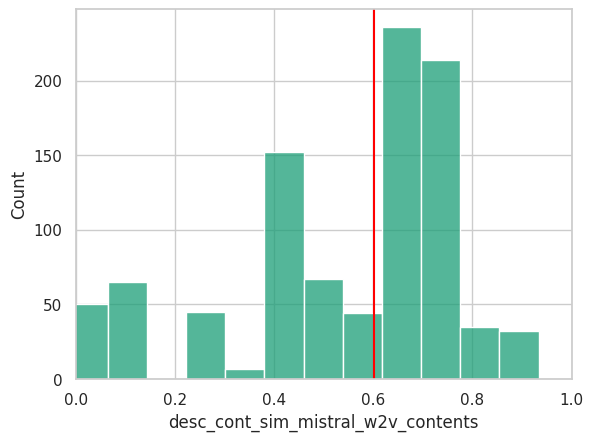

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_w2v_contents'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_w2v_contents'])
plt.axvline(xmedian, color='red')

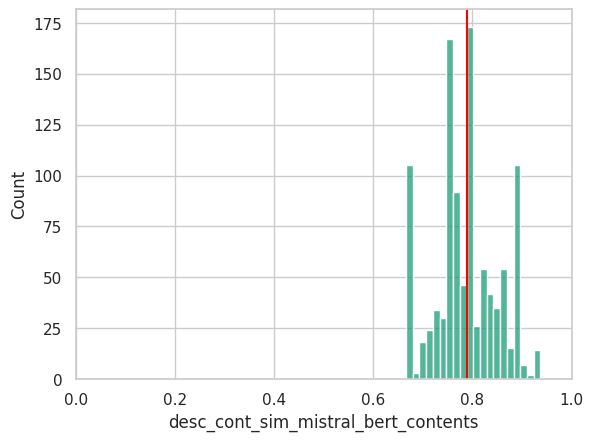

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_bert_contents'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_bert_contents'])
plt.axvline(xmedian, color='red')

one-shot

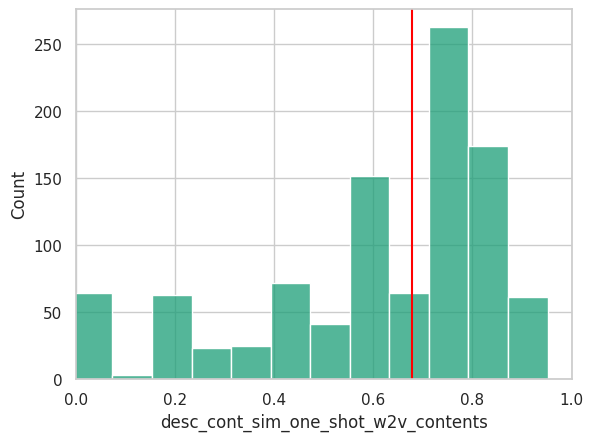

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_w2v_contents'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_w2v_contents'])
plt.axvline(xmedian, color='red')

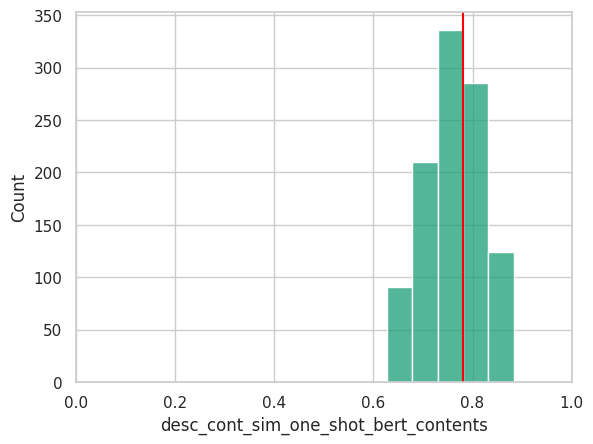

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_bert_contents'], bins=5)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_bert_contents'])
plt.axvline(xmedian, color='red')

Описание

zero-shot

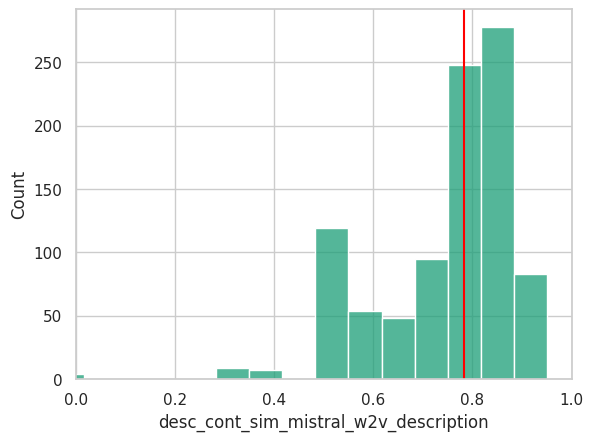

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_w2v_description'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_w2v_description'])
plt.axvline(xmedian, color='red')

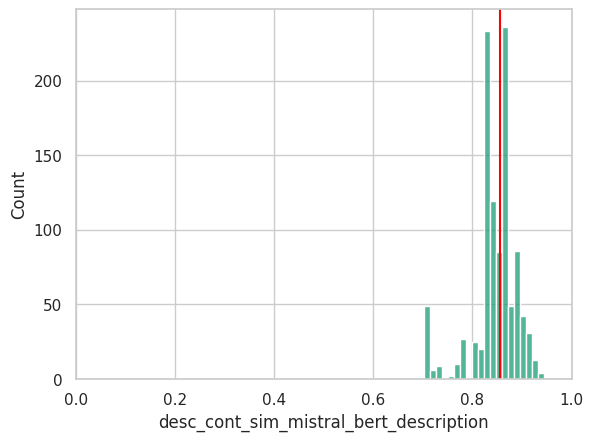

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_mistral_bert_description'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_mistral_bert_description'])
plt.axvline(xmedian, color='red')

one-shot

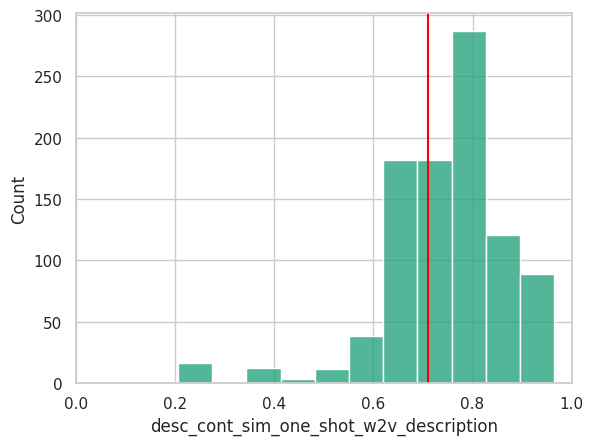

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_w2v_description'], bins=20)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_w2v_description'])
plt.axvline(xmedian, color='red')

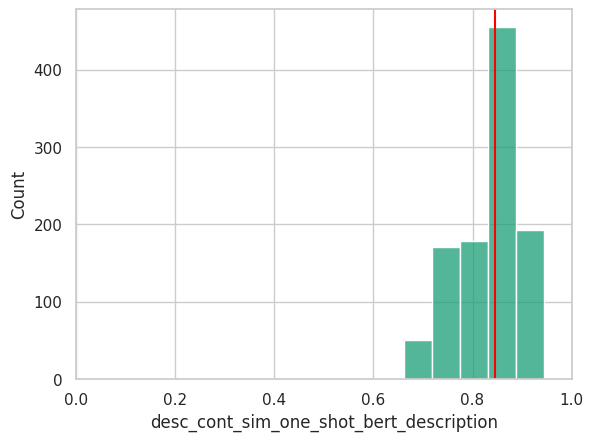

In [ ]:
sns.histplot(data = ud_df['desc_cont_sim_one_shot_bert_description'], bins=5)
plt.xlim(0, 1)
xmedian = np.median(ud_df['desc_cont_sim_one_shot_bert_description'])
plt.axvline(xmedian, color='red')

Вывод: Tiny BERT показал лучшие результаты по сравнению с w2v, т.к. у него среднее косинусное сходство выше, а разброс меньше. Это связано с тем, что в Tiny BERT использовалось гораздо больше слов, чем в w2v токенайзере.

2. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования (`qualification`). Сравните результаты для обоих векторайзеров.

Содержание:

zero-shot

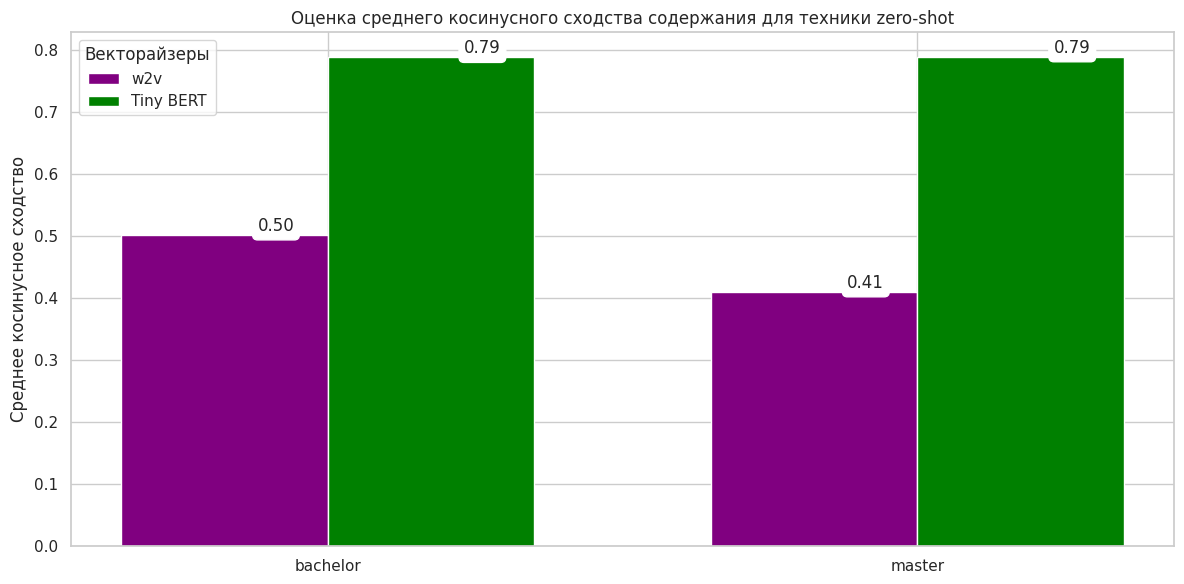

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('qualification').agg({
    'desc_cont_sim_mistral_w2v_contents': 'mean',
    'desc_cont_sim_mistral_bert_contents': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['qualification']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_mistral_w2v_contents'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_mistral_bert_contents'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['qualification'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства содержания для техники zero-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_mistral_w2v_contents'],
                                  grouped['desc_cont_sim_mistral_bert_contents'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

one-shot

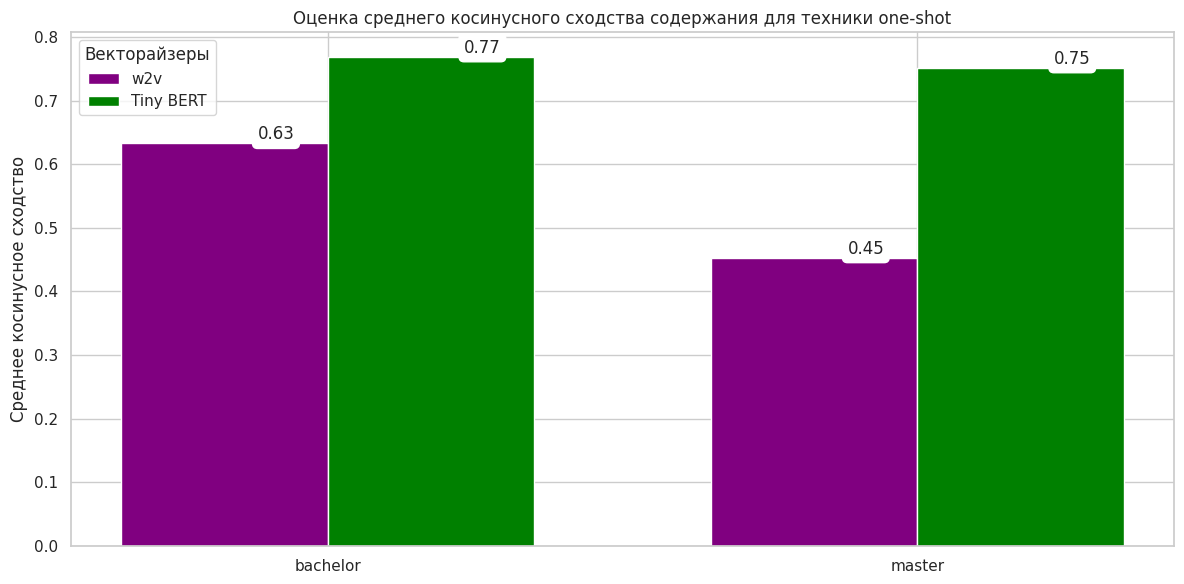

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('qualification').agg({
    'desc_cont_sim_one_shot_w2v_contents': 'mean',
    'desc_cont_sim_one_shot_bert_contents': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['qualification']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_one_shot_w2v_contents'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_one_shot_bert_contents'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['qualification'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства содержания для техники one-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_one_shot_w2v_contents'],
                                  grouped['desc_cont_sim_one_shot_bert_contents'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

Описание:

zero-shot

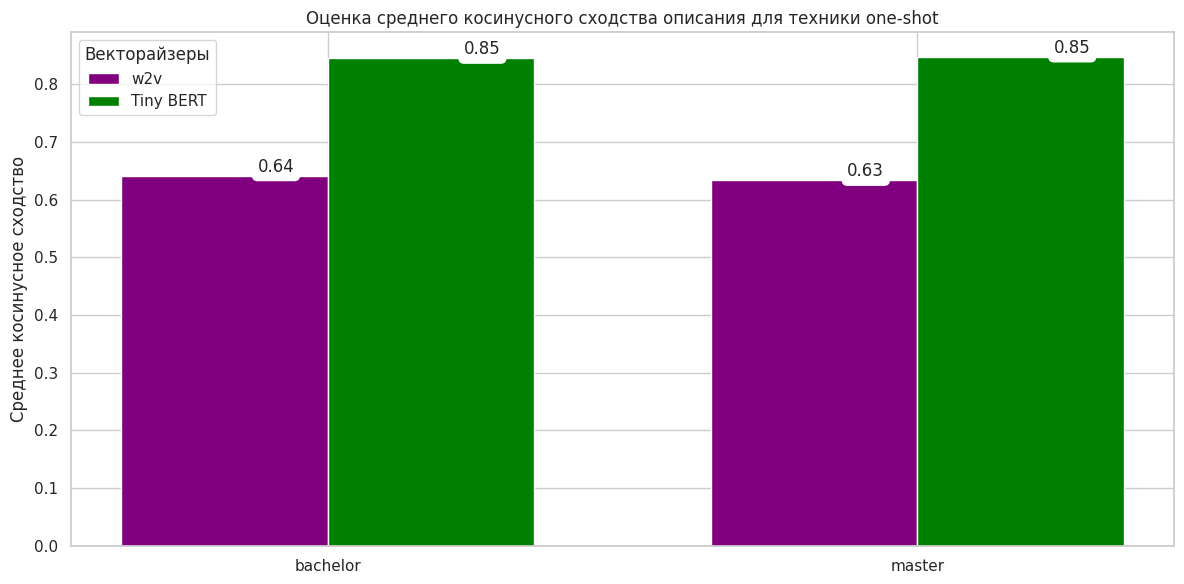

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('qualification').agg({
    'desc_cont_sim_mistral_w2v_description': 'mean',
    'desc_cont_sim_mistral_bert_description': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['qualification']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_mistral_w2v_description'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_mistral_bert_description'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['qualification'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства описания для техники one-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_mistral_w2v_description'],
                                  grouped['desc_cont_sim_mistral_bert_description'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

one-shot

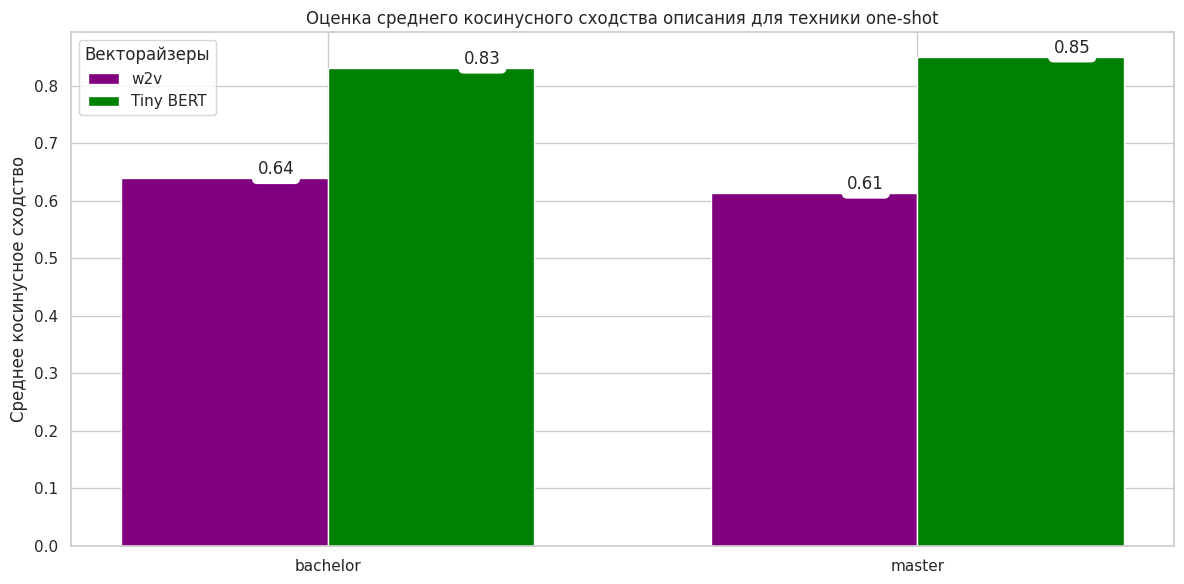

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('qualification').agg({
    'desc_cont_sim_one_shot_w2v_description': 'mean',
    'desc_cont_sim_one_shot_bert_description': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['qualification']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_one_shot_w2v_description'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_one_shot_bert_description'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['qualification'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства описания для техники one-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_one_shot_w2v_description'],
                                  grouped['desc_cont_sim_one_shot_bert_description'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

Вывод: Для каждой из используемых техник оценка среднего косинусного сходства для векторайзера Tiny BERT выше (в среднем около 0.8), чем для w2v (в среднем около 0.65). Это различие в оценке сходства сгенерированного и краткого описания скорее всего обусловлено также тем, что модель BERT обучается на большем наборе данных и знает больше слов, чем w2v, соответственно может лучше сравнить контексты сгенерированнного и реального текстов.

3. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по году (`start_year`). Сравните результаты для обоих векторайзеров.

Содержание:

zero-shot

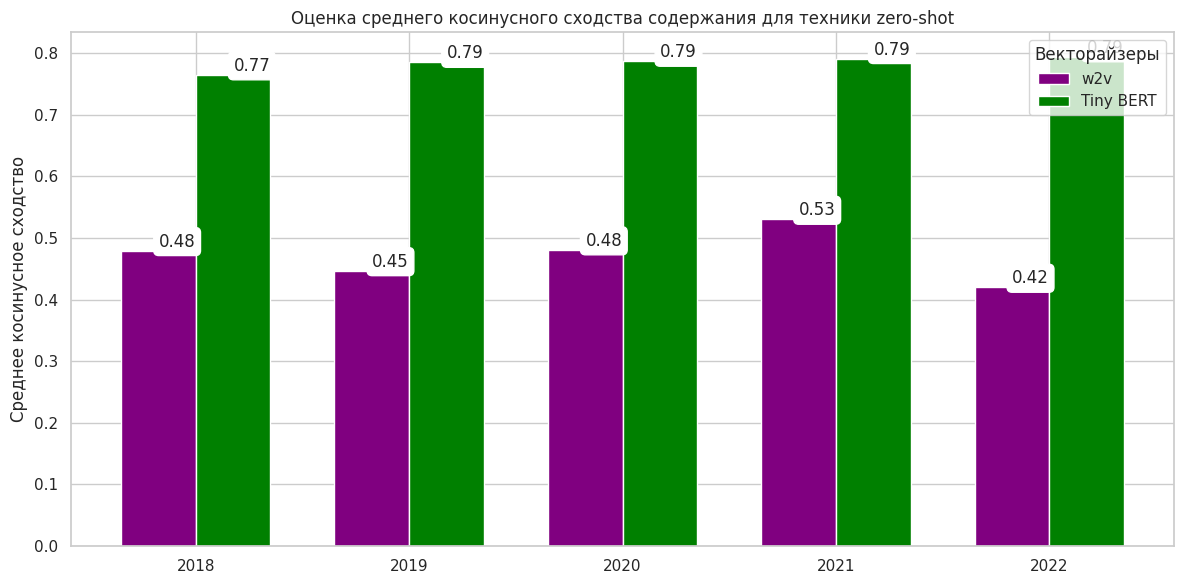

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('start_year').agg({
    'desc_cont_sim_mistral_w2v_contents': 'mean',
    'desc_cont_sim_mistral_bert_contents': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['start_year']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_mistral_w2v_contents'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_mistral_bert_contents'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['start_year'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства содержания для техники zero-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_mistral_w2v_contents'],
                                  grouped['desc_cont_sim_mistral_bert_contents'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

one-shot

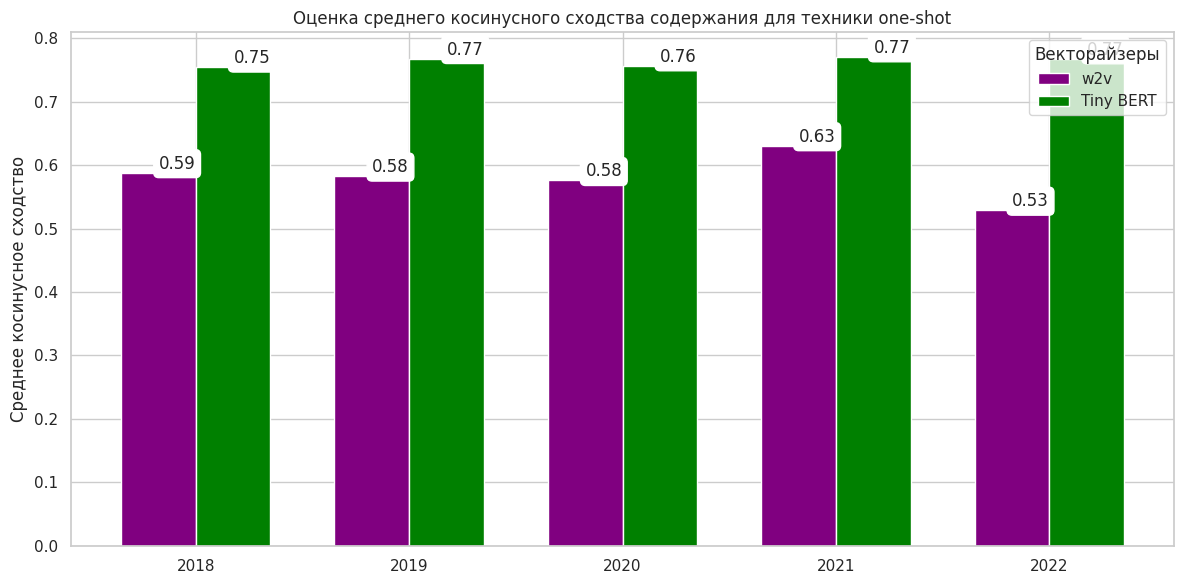

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('start_year').agg({
    'desc_cont_sim_one_shot_w2v_contents': 'mean',
    'desc_cont_sim_one_shot_bert_contents': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['start_year']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_one_shot_w2v_contents'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_one_shot_bert_contents'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['start_year'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства содержания для техники one-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_one_shot_w2v_contents'],
                                  grouped['desc_cont_sim_one_shot_bert_contents'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

Описание

zero-shot

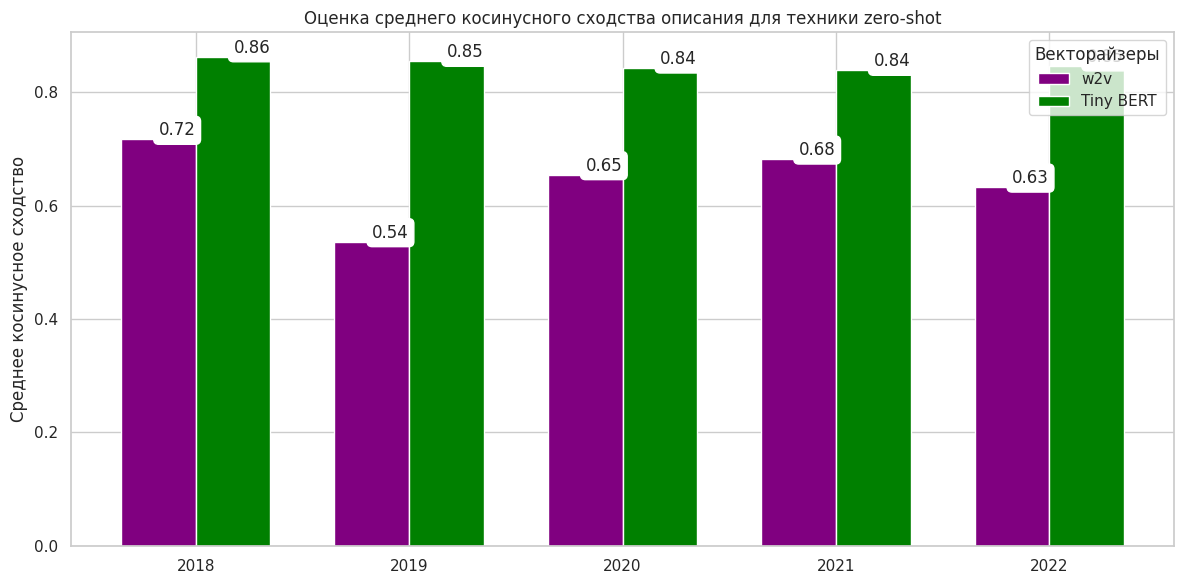

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('start_year').agg({
    'desc_cont_sim_mistral_w2v_description': 'mean',
    'desc_cont_sim_mistral_bert_description': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['start_year']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_mistral_w2v_description'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_mistral_bert_description'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['start_year'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства описания для техники zero-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_mistral_w2v_description'],
                                  grouped['desc_cont_sim_mistral_bert_description'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

one-shot

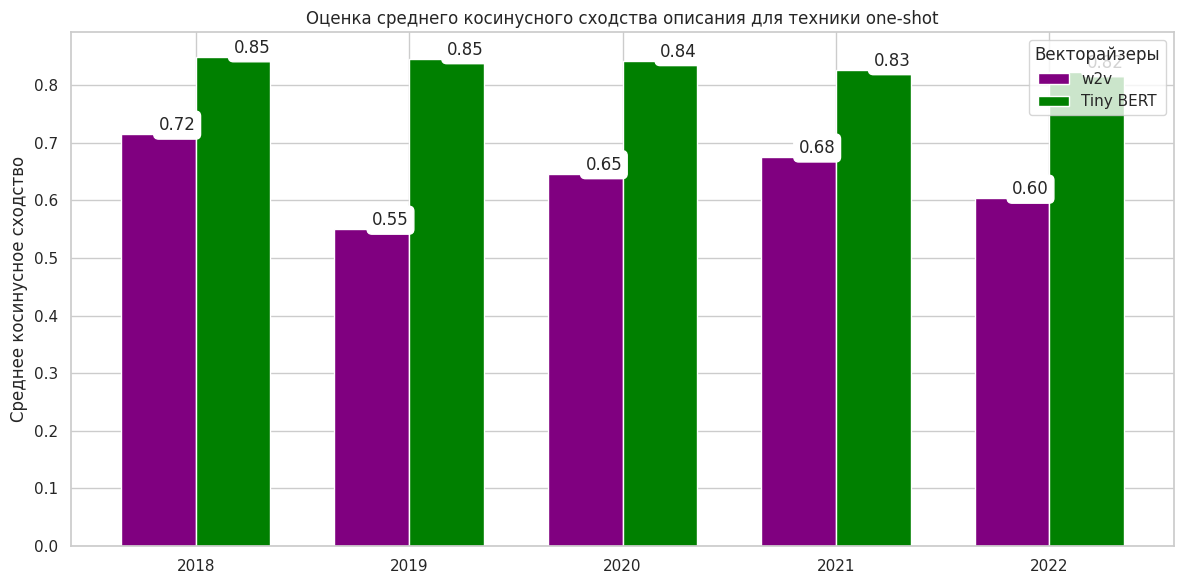

In [ ]:
# Группируем данные по уровню образования
grouped = ud_df.groupby('start_year').agg({
    'desc_cont_sim_one_shot_w2v_description': 'mean',
    'desc_cont_sim_one_shot_bert_description': 'mean'
}).reset_index()

# Создаем цветовую палитру
colors = ['purple', 'green']

# Создаем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(grouped['start_year']))
width = 0.35

ax.bar(x - width / 2, grouped['desc_cont_sim_one_shot_w2v_description'],
       color=colors[0], label='w2v', width=width)
ax.bar(x + width / 2, grouped['desc_cont_sim_one_shot_bert_description'],
       color=colors[1], label='Tiny BERT', width=width)

# Добавляем сетку и легенду
ax.set_xticks(x)
ax.set_xticklabels(grouped['start_year'])
ax.set_ylabel('Среднее косинусное сходство')
ax.set_title('Оценка среднего косинусного сходства описания для техники one-shot')
ax.legend(title='Векторайзеры')

# Добавляем точечную оценку
for i, (w2v, bert) in enumerate(zip(grouped['desc_cont_sim_one_shot_w2v_description'],
                                  grouped['desc_cont_sim_one_shot_bert_description'])):
    ax.text(i - width/4, w2v, f'{w2v:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))
    ax.text(i + width*3/4, bert, f'{bert:.2f}', ha='center', va='bottom',
            bbox=dict(boxstyle="round", ec="white", fc="white"))

plt.tight_layout()
plt.show()

Вывод: Векторайзер Tiny BERT показывает примерно одинаковый результат для всех годов в отличие от w2v, что ещё раз подтверждает, что w2v менее стабилен, так как обучен на меньших данных, чем BERT.

4. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования и годам, но только с помощью векторов  w2v.

In [ ]:
import plotly.express as px
grouped_by_year_and_qualification = ud_df.groupby(['start_year', 'qualification'])

zero-shot contents

In [ ]:
fig = px.bar(grouped_by_year_and_qualification['desc_cont_sim_mistral_w2v_contents'].mean().reset_index(name='mean'), x = 'start_year', y = 'mean', color = 'qualification', barmode="group")
fig.show()

one-shot contents

In [ ]:
fig = px.bar(grouped_by_year_and_qualification['desc_cont_sim_one_shot_w2v_contents'].mean().reset_index(name='mean'), x = 'start_year', y = 'mean', color = 'qualification', barmode="group")
fig.show()

zero-shot description

In [ ]:
fig = px.bar(grouped_by_year_and_qualification['desc_cont_sim_mistral_w2v_description'].mean().reset_index(name='mean'), x = 'start_year', y = 'mean', color = 'qualification', barmode="group")
fig.show()

one-shot description

In [ ]:
fig = px.bar(grouped_by_year_and_qualification['desc_cont_sim_one_shot_w2v_description'].mean().reset_index(name='mean'), x = 'start_year', y = 'mean', color = 'qualification', barmode="group")
fig.show()

Вывод: Для содержаний лучшую схожесть показывает методика one_shot - результат для баколавров в среднем 0.6, для магистров - 0.4. Модель mistral показала среднюю схожесть бакалавров по годам 0.5, магистров - около 0.35. Можно заметить, что косинусное сходство магистров снижается - возможно это происходит из-за более сложных слов (особенно в описании) в текстах, чем у бакалавров.

5. Оцените средние значения сходства эталонных данных и генераций обеими техниками в разрезе по уровню образования (`qualification`). То есть постройте такую диграмму, по которой будет видно, для какого уровня образования какая из техник в среднем дает более близкий к эталонному контекст.

Содержание:

In [ ]:
zero_shot_contents_w2v_sim = ud_df.groupby(['qualification'])['desc_cont_sim_mistral_w2v_contents'].mean().reset_index(name='mean')
zero_shot_contents_bert_sim = ud_df.groupby(['qualification'])['desc_cont_sim_mistral_bert_contents'].mean().reset_index(name='mean')
one_shot_contents_w2v_sim = ud_df.groupby(['qualification'])['desc_cont_sim_one_shot_w2v_contents'].mean().reset_index(name='mean')
one_shot_contents_bert_sim = ud_df.groupby(['qualification'])['desc_cont_sim_one_shot_bert_contents'].mean().reset_index(name='mean')

zero_shot_contents_bert_sim['type'] = 'zero-shot bert'
zero_shot_contents_w2v_sim['type'] = 'zero-shot w2v'
one_shot_contents_bert_sim['type'] = 'one-shot bert'
one_shot_contents_w2v_sim['type'] = 'one-shot w2v'

frames = [zero_shot_contents_bert_sim, zero_shot_contents_w2v_sim, one_shot_contents_bert_sim, one_shot_contents_w2v_sim]

fig = px.bar(pd.concat(frames), x = 'qualification', y = 'mean', color = 'type', barmode="group")
fig.show()

Описание:

In [ ]:
zero_shot_description_w2v_sim = ud_df.groupby(['qualification'])['desc_cont_sim_mistral_w2v_description'].mean().reset_index(name='mean')
zero_shot_description_bert_sim = ud_df.groupby(['qualification'])['desc_cont_sim_mistral_bert_description'].mean().reset_index(name='mean')
one_shot_description_w2v_sim = ud_df.groupby(['qualification'])['desc_cont_sim_one_shot_w2v_description'].mean().reset_index(name='mean')
one_shot_description_bert_sim = ud_df.groupby(['qualification'])['desc_cont_sim_one_shot_bert_description'].mean().reset_index(name='mean')

zero_shot_description_bert_sim['type'] = 'zero-shot bert'
zero_shot_description_w2v_sim['type'] = 'zero-shot w2v'
one_shot_description_bert_sim['type'] = 'one-shot bert'
one_shot_description_w2v_sim['type'] = 'one-shot w2v'

frames = [zero_shot_description_bert_sim, zero_shot_description_w2v_sim, one_shot_description_bert_sim, one_shot_description_w2v_sim]

fig = px.bar(pd.concat(frames), x = 'qualification', y = 'mean', color = 'type', barmode="group")
fig.show()

Вывод: и для описаний, и для содержаний лучшую схожесть показывает Tiny BERT. Для содержаний незначительно лучше модель zero-shot, для содержаний - модель one shot. Модели w2v показывают низкую схожесть, особенно для содержаний, особенно для магистратур.

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab4`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**